In [1]:
import torch
import torch.nn as nn
# from generate_data import *
import matplotlib.pyplot as plt
import numpy as np
import math 
from load_matlab_timedata import get_data_from
import sklearn.preprocessing 
from tqdm import tqdm_notebook as tqdm
import random
import yaml
import h5py
from torch.utils.data import Dataset, DataLoader, SequentialSampler, BatchSampler
import logging
import datetime
import os
import time
import torch.nn.functional as F
from src.TSGenerator import f_Y, f_X, dY_dt, f_X_inv, get_func_timeseries
from src.DataLoader import TimeSeriesDataset
from src.model_utils import init_logger, plot_shared_scale, plot_multiscale
from src.Model import LSTM
from src.Losses import myLoss
import pprint

In [2]:
! ls DC_motor_simulation

dc_engine_random_sig_const_periods.slx		    DC_motor_simulation.prj
dc_engine_random_sig_random_period_gaus_noise.slx   diff_eq_system.slx
dc_engine_random_sig_random_period_gaus_noise.slxc  diff_eq_system.slx.original
dc_engine_random_sig_random_period.slx		    res.mat
dc_engine_random_sig_random_period.slxc		    resources
dc_engine_random_sig_random_period.slx.original     slprj


In [3]:
plt.rcParams['figure.figsize'] = 20, 7.

In [4]:
CONFIG_FILENAME = "model_params.yaml"

In [5]:
with open(CONFIG_FILENAME, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)

In [6]:
to_generate_data = config['to_generate_data']
if to_generate_data:
    p_gen = config['generator_params']
    a = p_gen['a']
is_debug = config['is_debug']
if is_debug:
    p_debug = config['debug_params']
    pprint.pprint(p_debug)
    

In [7]:
pprint.pprint(config)

{'data_params': {'leave_nth': 13,
                 'mat_file': 'DC_motor_simulation/res.mat',
                 'need_normalize': True,
                 'test_size': 0.3},
 'exp_path': 'only_batches',
 'generator_params': {'a': -1, 'f_X': 'math.sin', 'f_Y': 'math.cos'},
 'is_debug': False,
 'network_params': {'dtype': 'torch.float',
                    'hidden_size': 16,
                    'input_size': 64,
                    'num_layers': 2,
                    'output_dim': 1,
                    'per_element': True,
                    'retrospective_steps': 64},
 'to_generate_data': True,
 'train_params': {'batch_size': 128,
                  'learning_rate': 0.01,
                  'loss_fn': 'mse',
                  'num_epochs': 15,
                  'optimizer': 'adam',
                  'reduction': 'sum'}}


In [8]:
p_data = config['data_params']
pprint.pprint(p_data)

{'leave_nth': 13,
 'mat_file': 'DC_motor_simulation/res.mat',
 'need_normalize': True,
 'test_size': 0.3}


In [9]:
p_net = config['network_params']
pprint.pprint(p_net)

{'dtype': 'torch.float',
 'hidden_size': 16,
 'input_size': 64,
 'num_layers': 2,
 'output_dim': 1,
 'per_element': True,
 'retrospective_steps': 64}


In [10]:
p_train = config['train_params']
pprint.pprint(p_train)

{'batch_size': 128,
 'learning_rate': 0.01,
 'loss_fn': 'mse',
 'num_epochs': 15,
 'optimizer': 'adam',
 'reduction': 'sum'}


In [11]:
if is_debug:
    x, y = get_func_timeseries(f_Y = f_Y, f_X = f_X)

In [12]:
#####################
# Set parameters
#####################
# # If `per_element` is True, then LSTM reads in one timestep at a time.
if  p_net['per_element']:
    lstm_input_size = 1
else:
    lstm_input_size = p_net['input_size']

In [13]:
init_logger(config)

logger inited to file [only_batcheslogs/exp_2019-04-22_01:01:22.log]


In [14]:
logging.info("Experiment started with params")
logging.info(f"data_par: {p_data}")
logging.info(f"net_par: {p_net}")
logging.info(f"train_par: {p_train}")

input shape (3001, 1)
input partition shape (901, 1)
output partition shape (901, 1)
stacked Y shape  (836, 2)
Y_tensor torch.Size([836, 2])
X_tensor torch.Size([64, 836, 1])


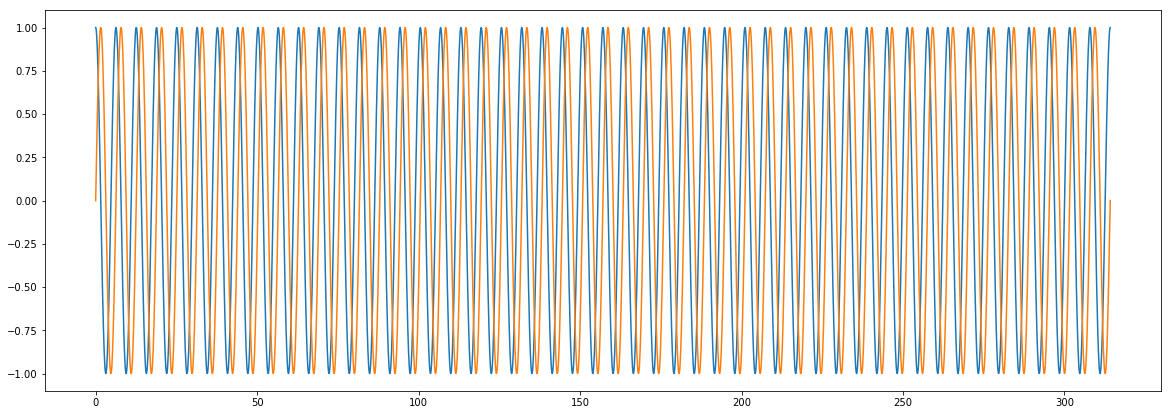

In [15]:
test_ts_ds = TimeSeriesDataset(config=config,
                               partition=(1 - p_data['test_size'], 1),                        
                               logging=logging)

input shape (3001, 1)
input partition shape (2100, 1)
output partition shape (2100, 1)
stacked Y shape  (2035, 2)
Y_tensor torch.Size([2035, 2])
X_tensor torch.Size([64, 2035, 1])


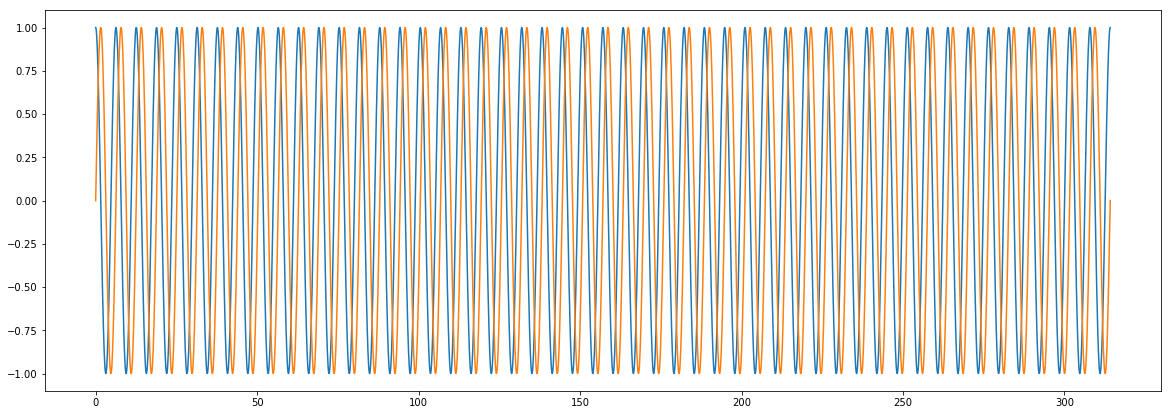

In [16]:
train_ts_ds = TimeSeriesDataset(config=config,
                                partition=(0, 1 - p_data['test_size']),
                                logging=logging)

In [17]:
train_dl = DataLoader(dataset = train_ts_ds,
                      batch_sampler = BatchSampler(
                          sampler = SequentialSampler(train_ts_ds), 
                          batch_size = p_train['batch_size'],
                          drop_last = True)
                     )
test_dl = DataLoader(dataset = test_ts_ds,
                     batch_sampler = BatchSampler(
                     sampler = SequentialSampler(test_ts_ds), 
                     batch_size = p_train['batch_size'], 
                     drop_last = True)
                    )

In [18]:
## Inspecting data we have

In [19]:
len(train_dl)

15

x :torch.Size([128, 64, 1])
y: torch.Size([128, 2])
y_last: (128,)


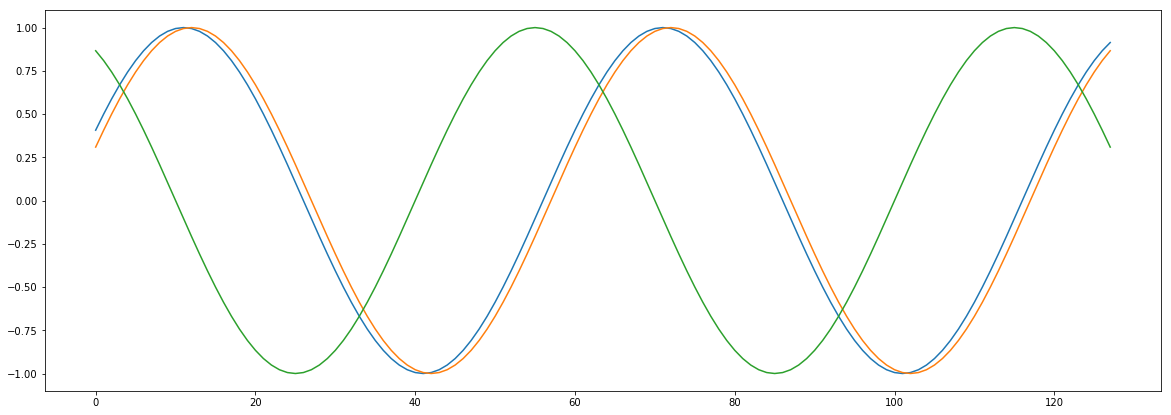

x :torch.Size([128, 64, 1])
y: torch.Size([128, 2])
y_last: (128,)


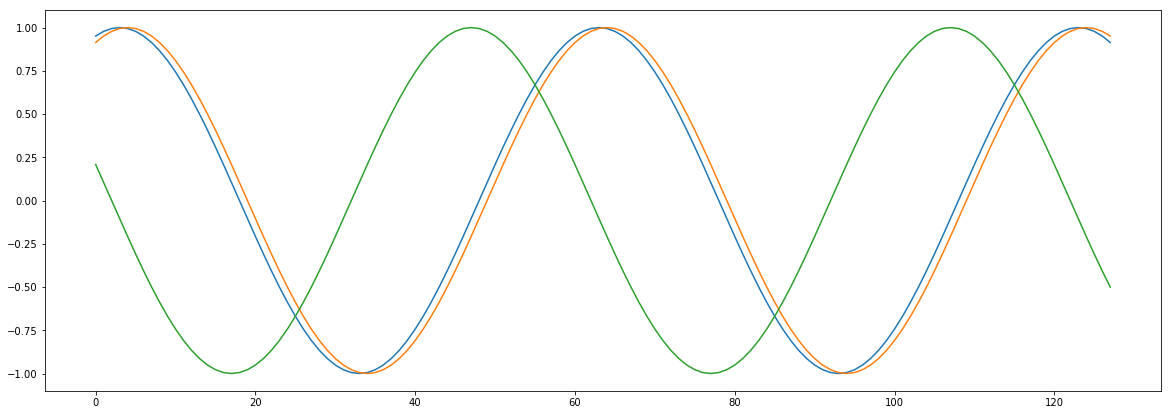

In [20]:
f, t = 0, 150
for i, batch in enumerate(train_dl):
    x, y, ind = batch
    print(f"x :{x.shape}")
    print(f"y: {y.shape}")
    y_kth = y.detach().numpy()[f:t, 0]
    print(f"y_last: {y_kth.shape}")
    x = x.transpose(0,1)
    plt.plot(x.detach().numpy()[-1][f:t])
    plt.plot(x.detach().numpy()[-2][f:t])
    plt.plot(y_kth)
    plt.show()
    if i == 1:
        break

In [21]:
model = LSTM(lstm_input_size,
             p_net['hidden_size'],
             batch_size=p_train['batch_size'],
             output_dim=p_net['output_dim'],
             num_layers=p_net['num_layers'])

loss_fn = myLoss

# if p_train['loss_fn'] == 'mse':  
#     loss_fn = torch.nn.MSELoss(reduction=p_train['reduction'])
# elif p_train['loss_fn'] == 'l1':  
#     loss_fn = torch.nn.L1Loss(reduction=p_train['reduction'])

if p_train['optimizer'] == "adam":
    optimiser = torch.optim.Adam(model.parameters(), lr=p_train['learning_rate'])

In [22]:
logging.info(f"Model n params: {model.get_num_params()}")

In [23]:
model.get_num_params()

3426.0

In [24]:
len(train_dl)

15

In [25]:
num_epochs = p_train['num_epochs']

In [26]:
logging.info("Training process START")

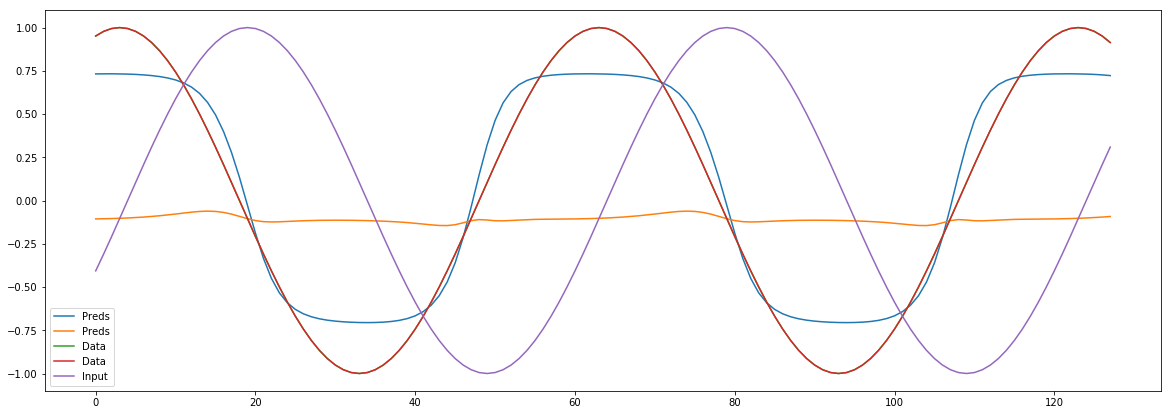

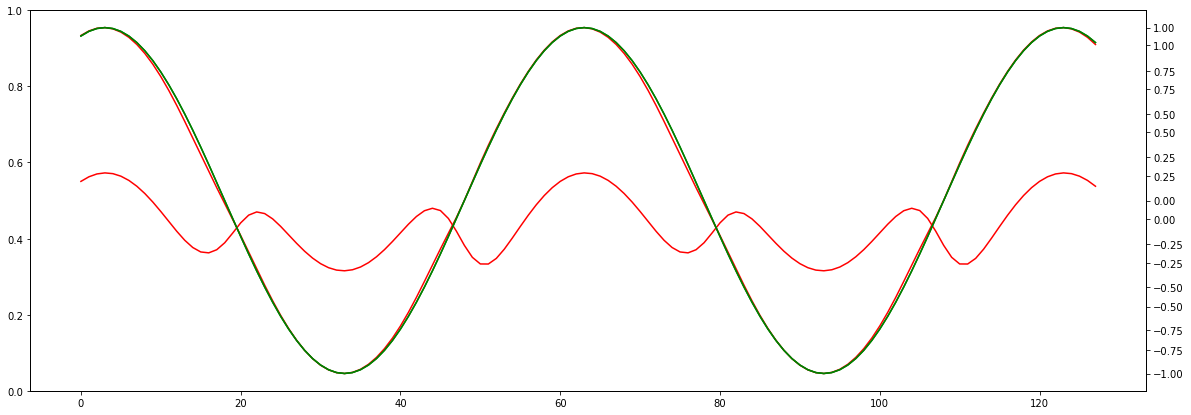

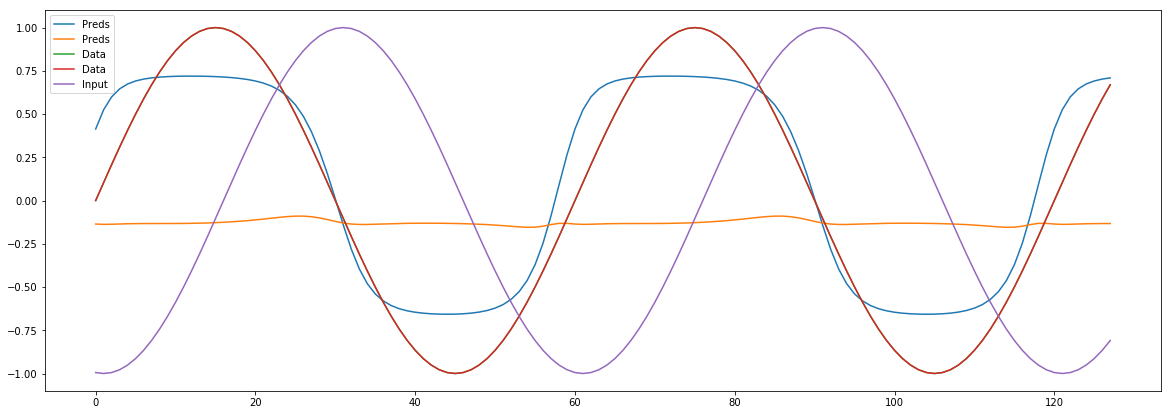

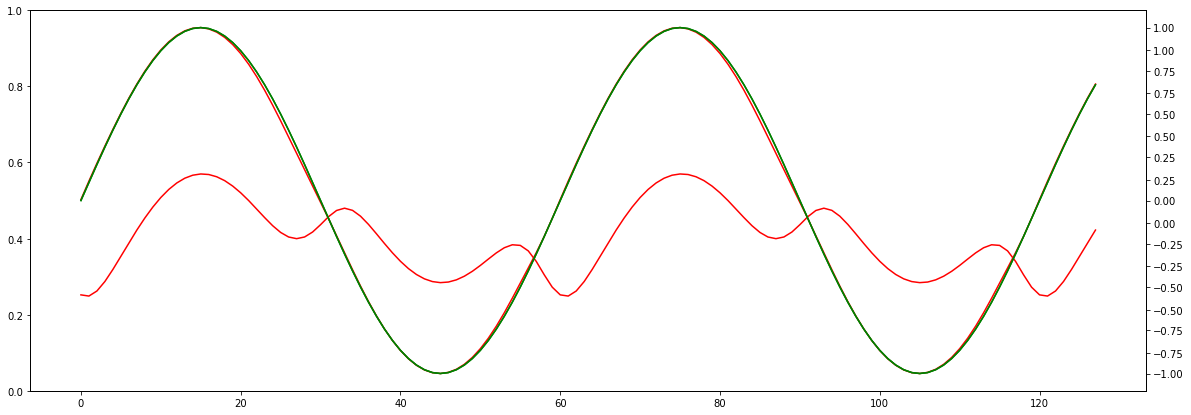

 Epoch [0]     
 train_loss[54.475982157389325]     
 eval_train[30.009649149576823]     
 eval_test[30.04011599222819] 


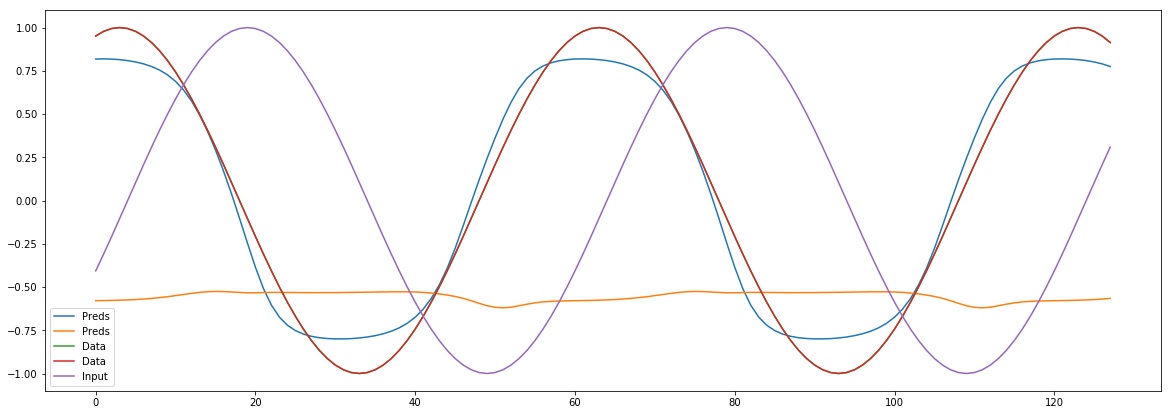

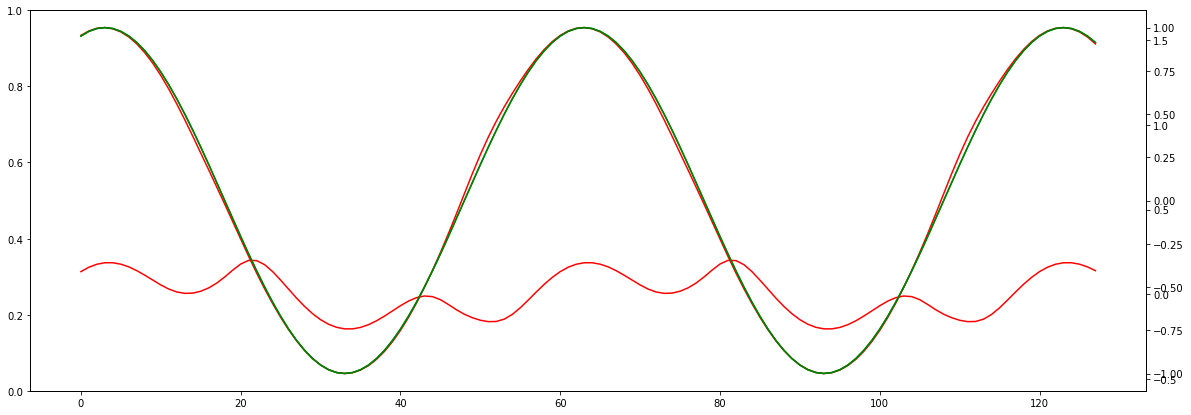

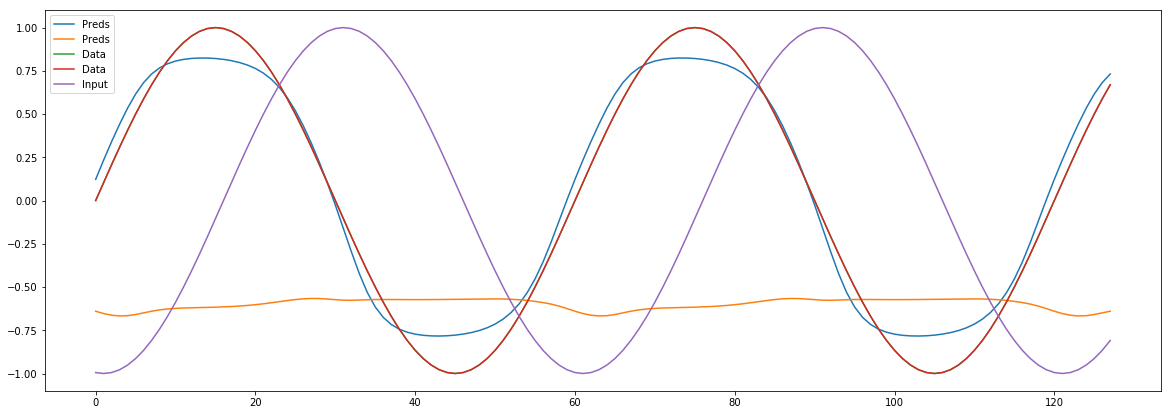

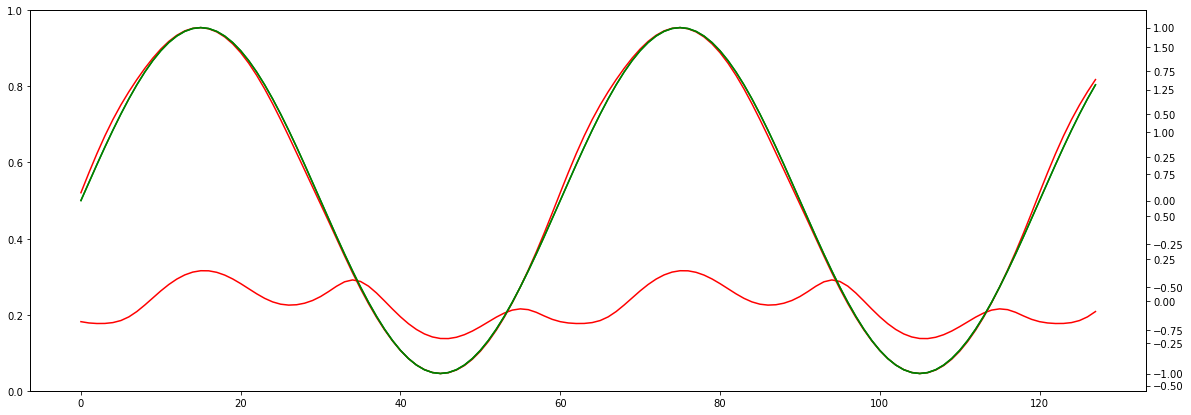

 Epoch [1]     
 train_loss[25.150104522705078]     
 eval_train[17.311919021606446]     
 eval_test[17.317793528238933] 


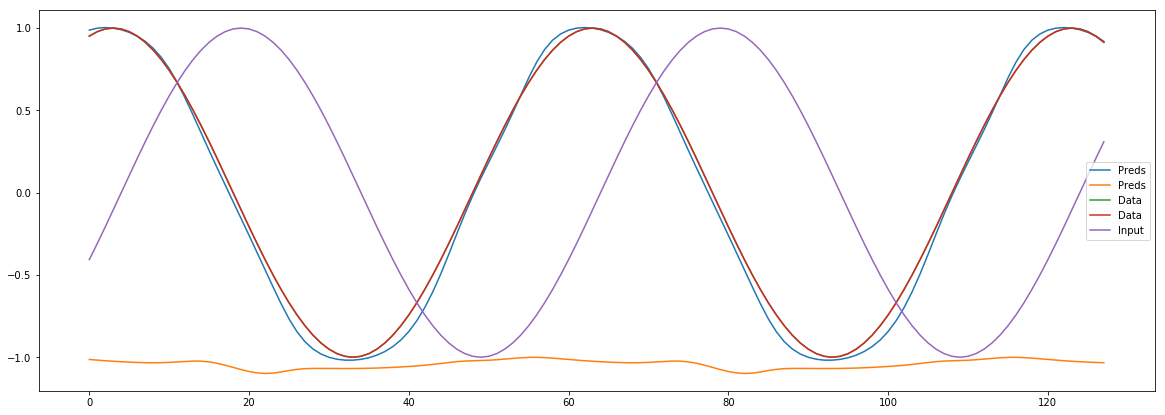

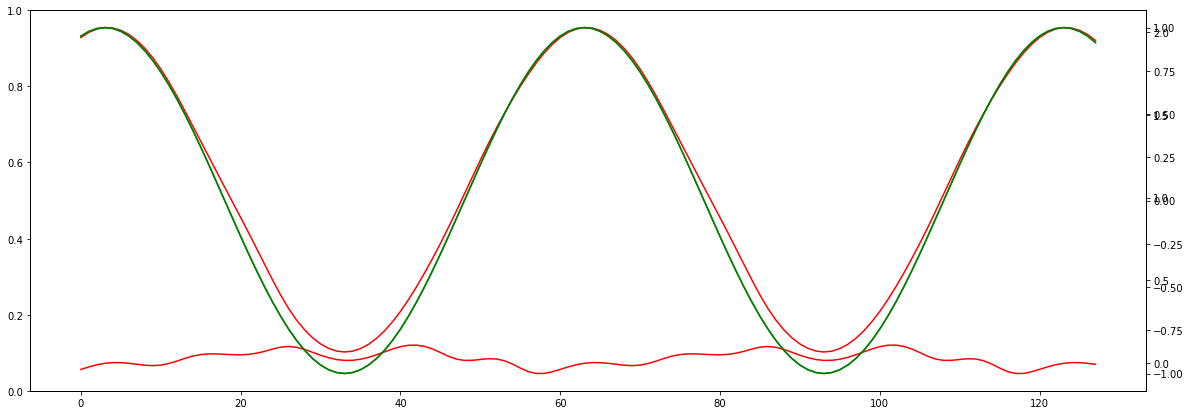

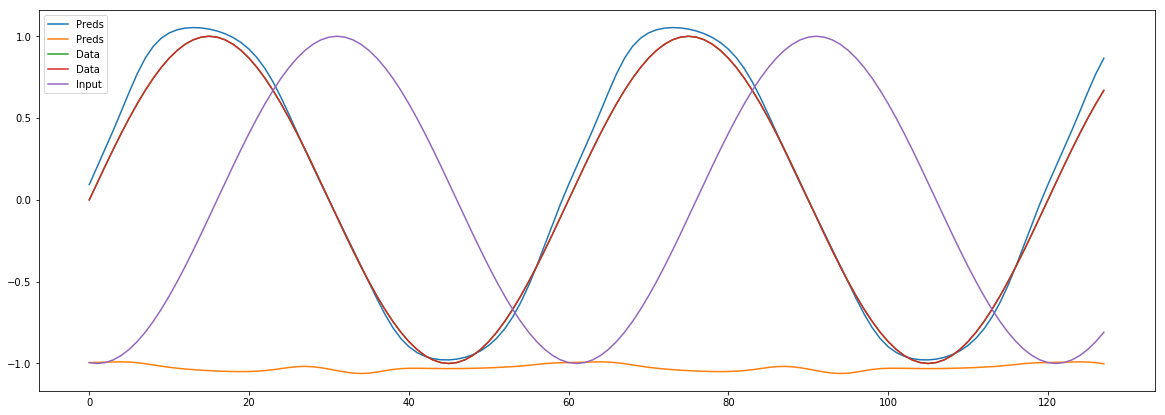

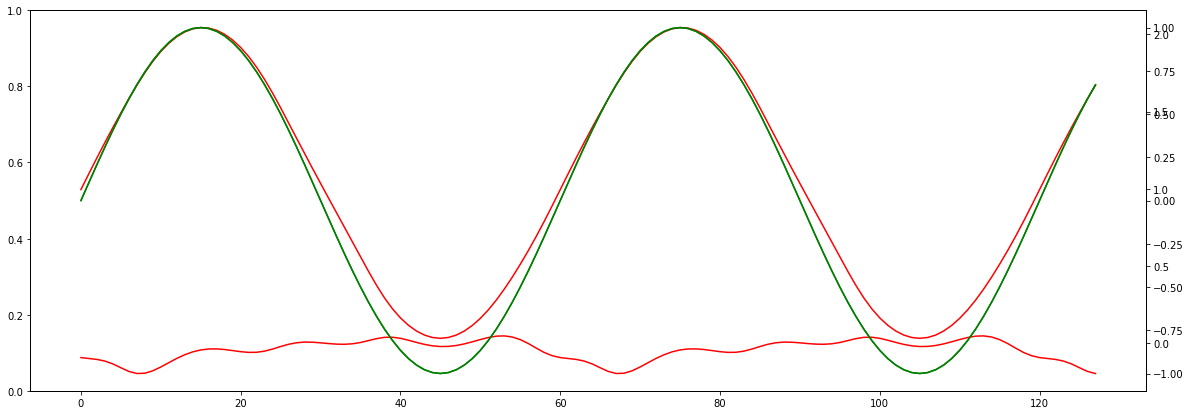

 Epoch [2]     
 train_loss[11.97653923034668]     
 eval_train[8.854378763834635]     
 eval_test[8.77092440923055] 


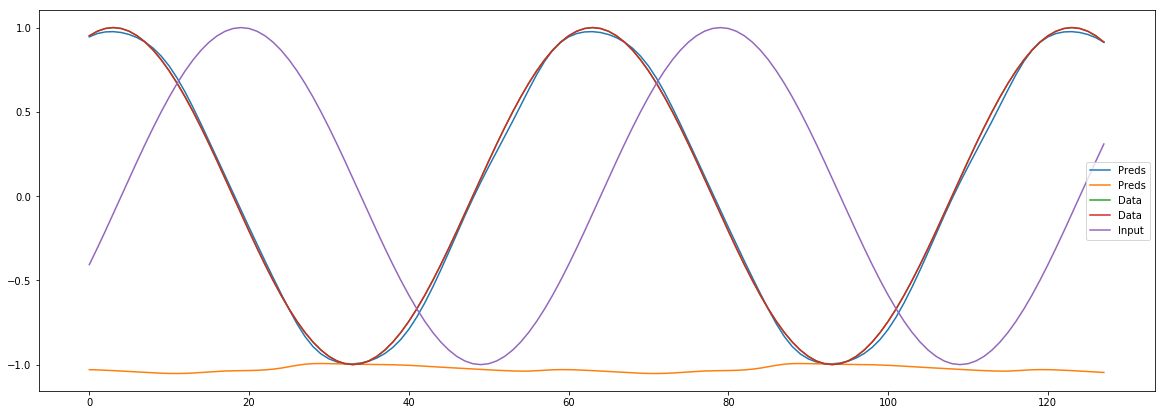

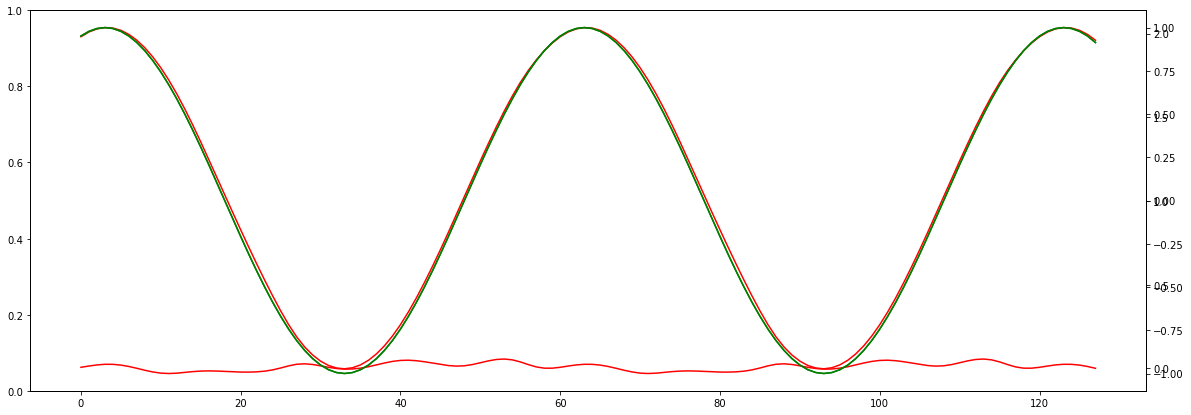

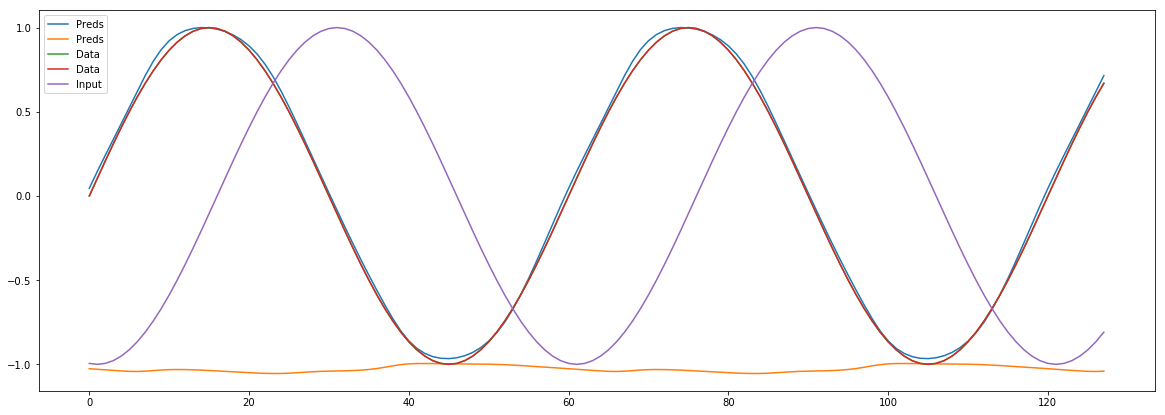

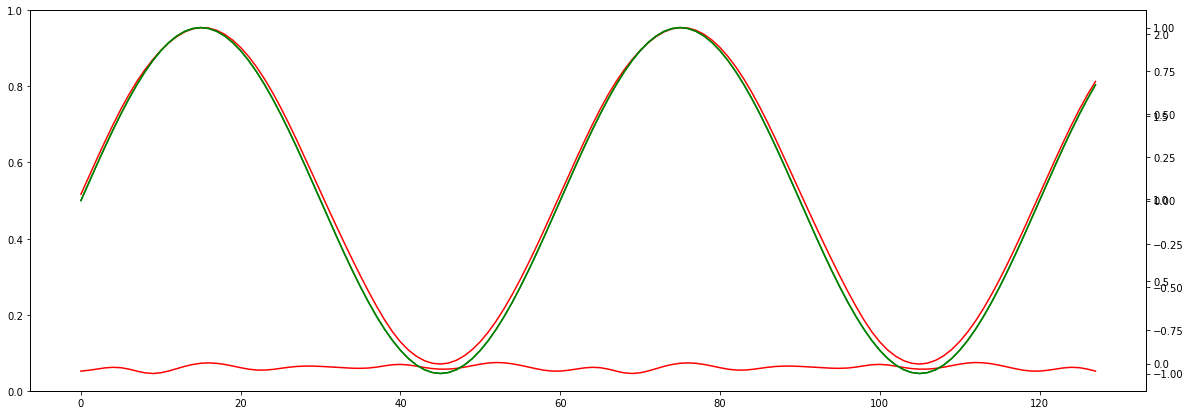

 Epoch [3]     
 train_loss[5.925337425867716]     
 eval_train[4.262430063883463]     
 eval_test[4.25300407409668] 


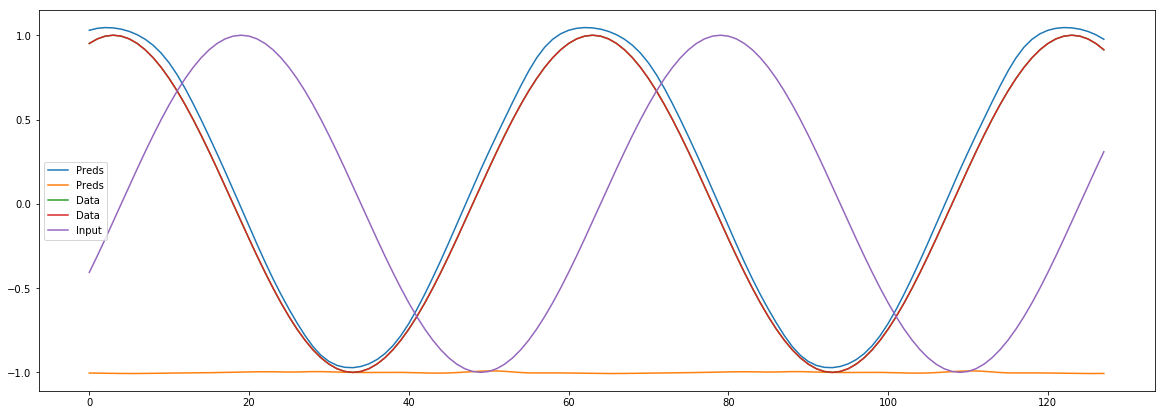

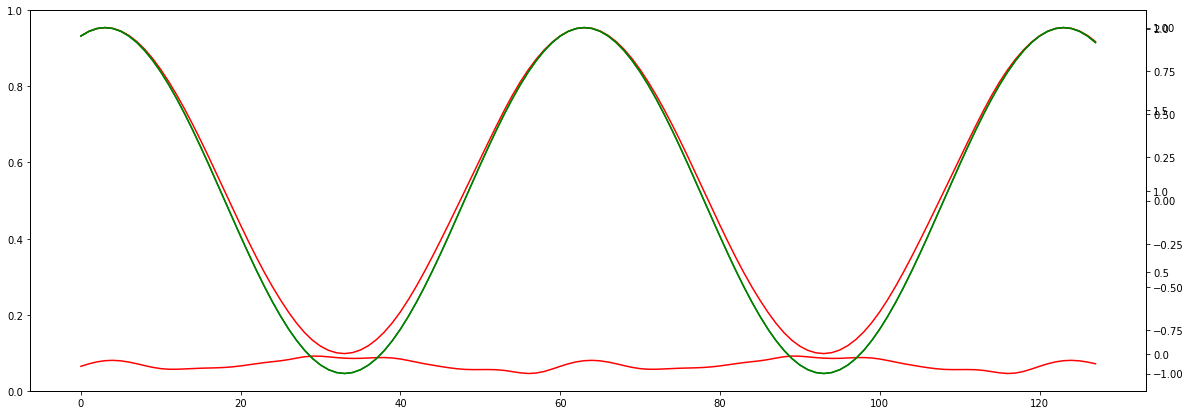

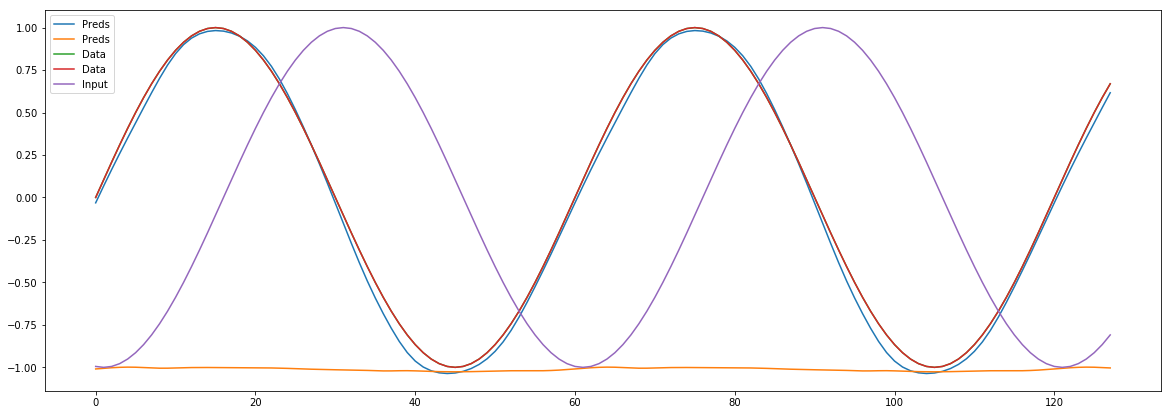

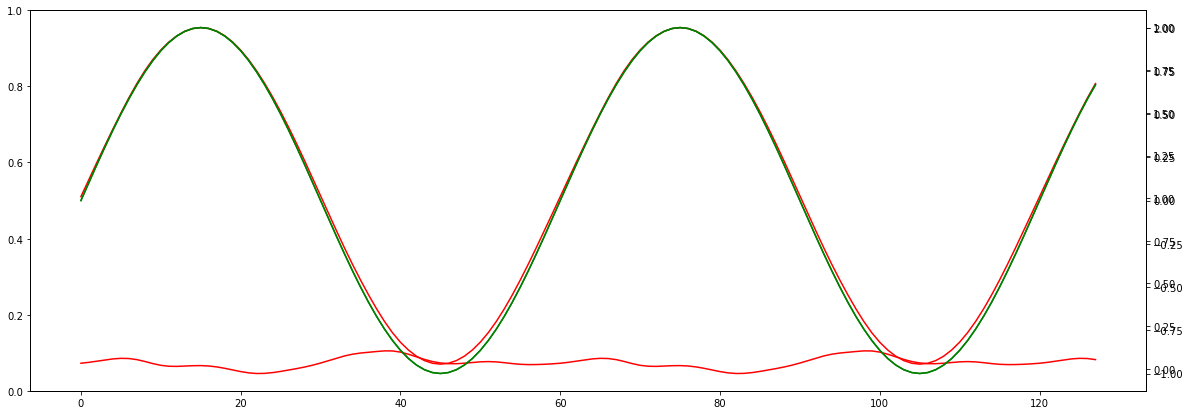

 Epoch [4]     
 train_loss[6.291887633005778]     
 eval_train[6.04165875116984]     
 eval_test[6.091483195622762] 


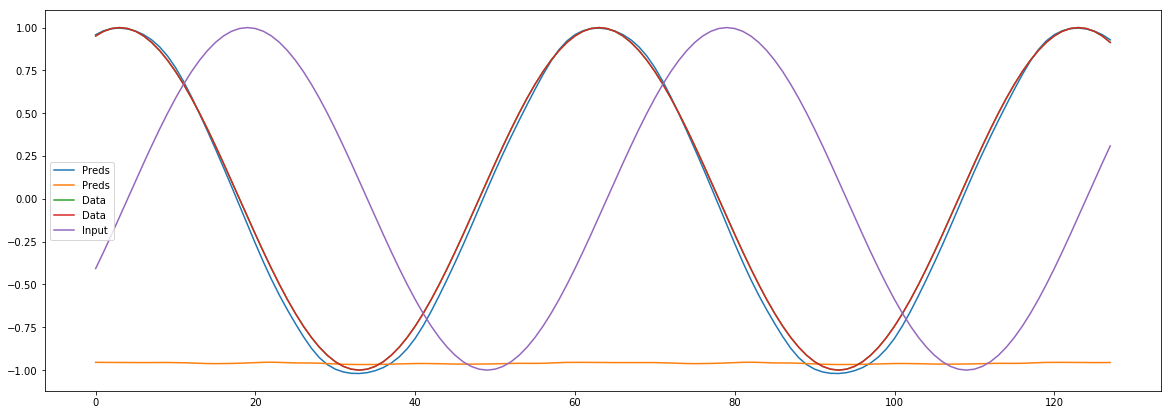

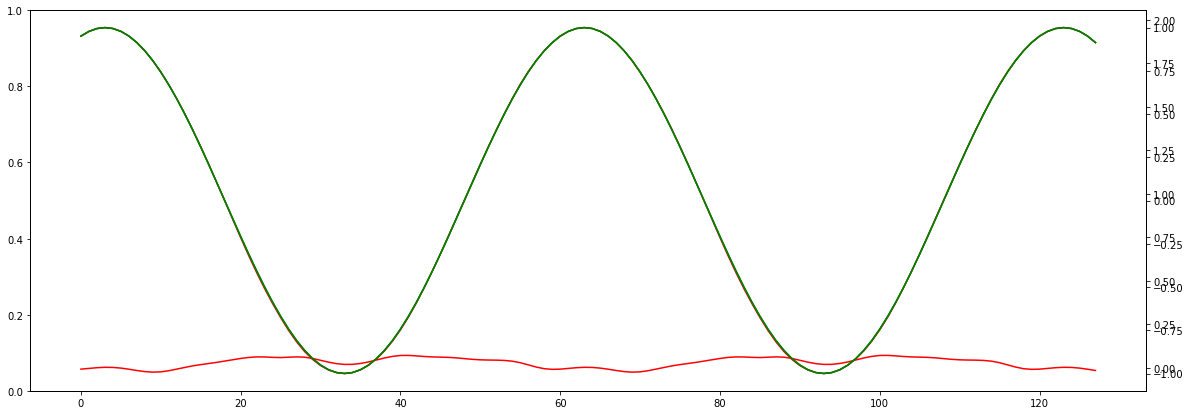

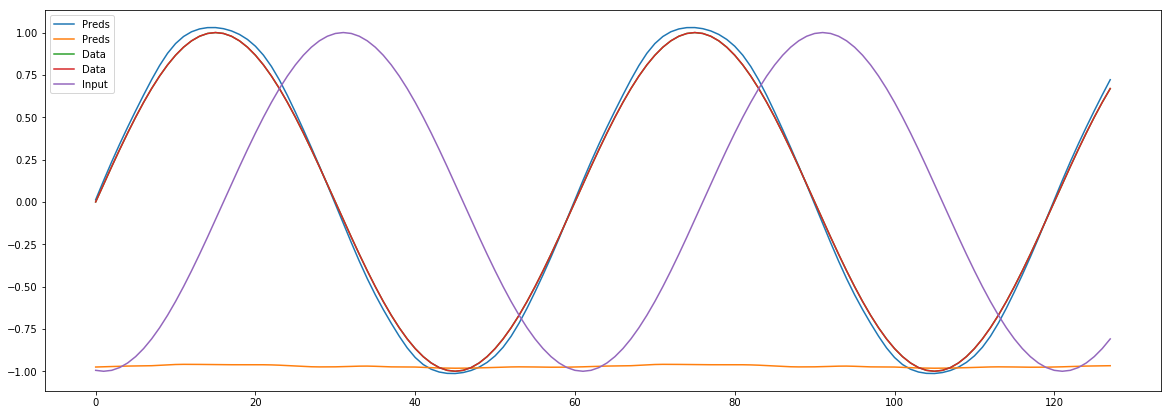

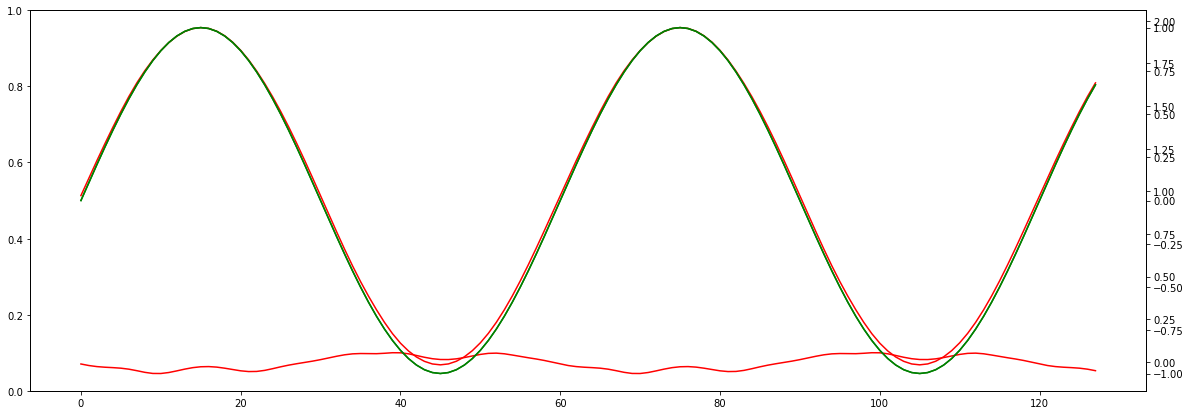

 Epoch [5]     
 train_loss[5.949575916926066]     
 eval_train[5.801863161722819]     
 eval_test[5.784149408340454] 


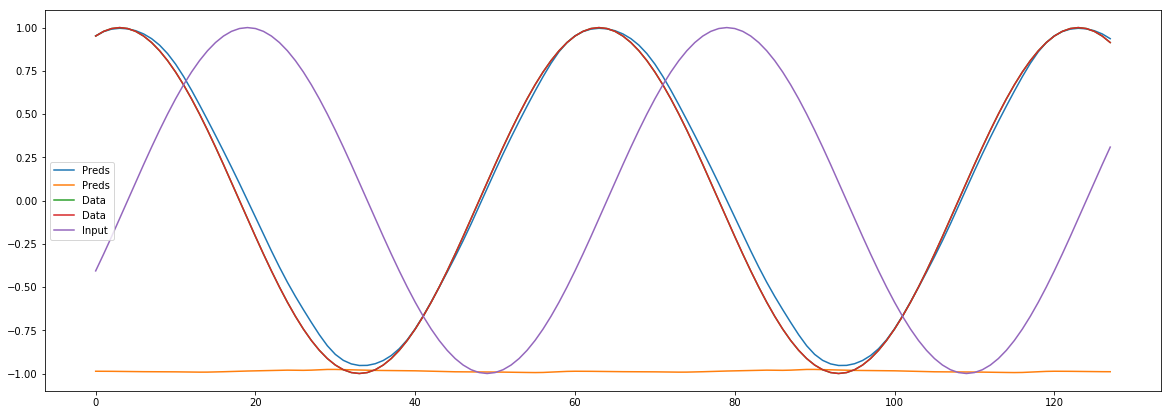

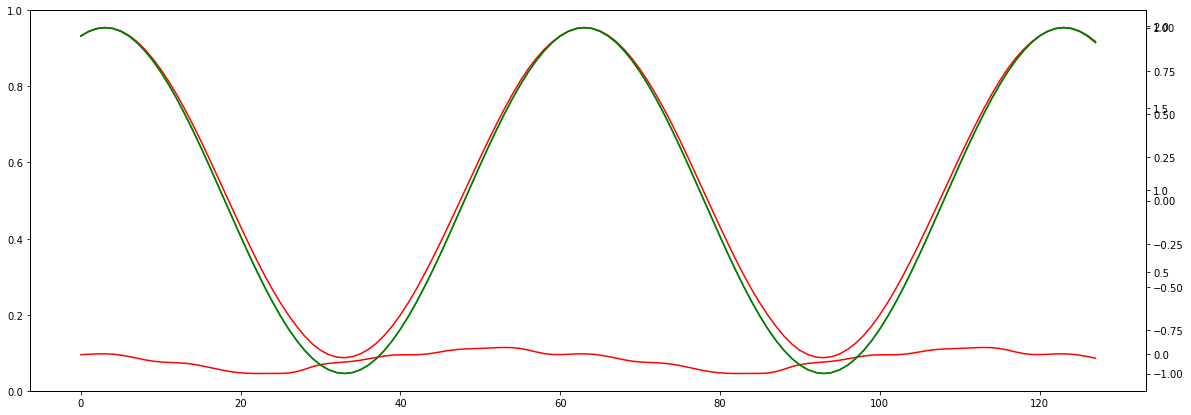

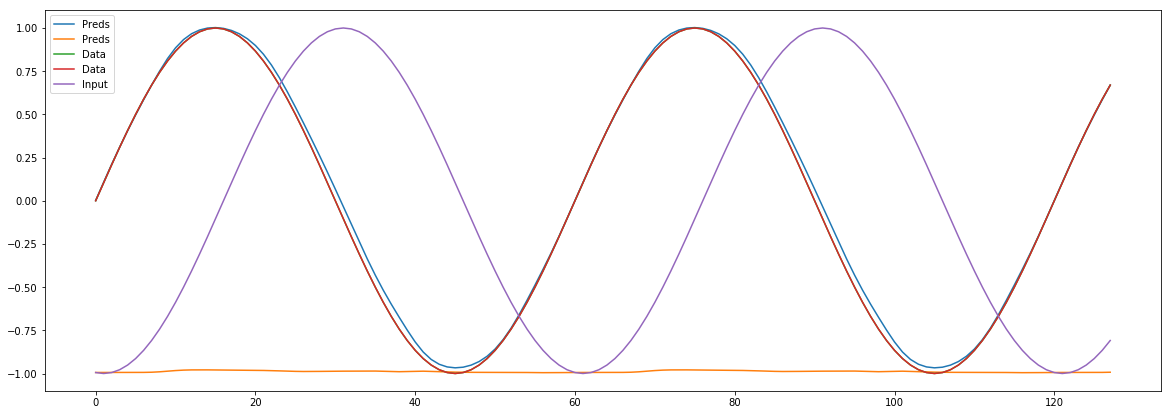

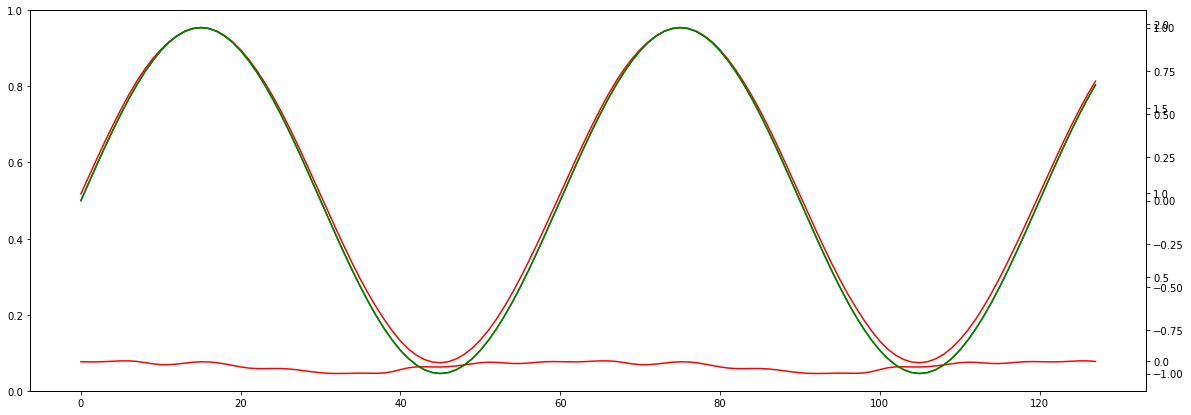

 Epoch [6]     
 train_loss[4.11661122639974]     
 eval_train[4.0870055516560875]     
 eval_test[4.115325450897217] 


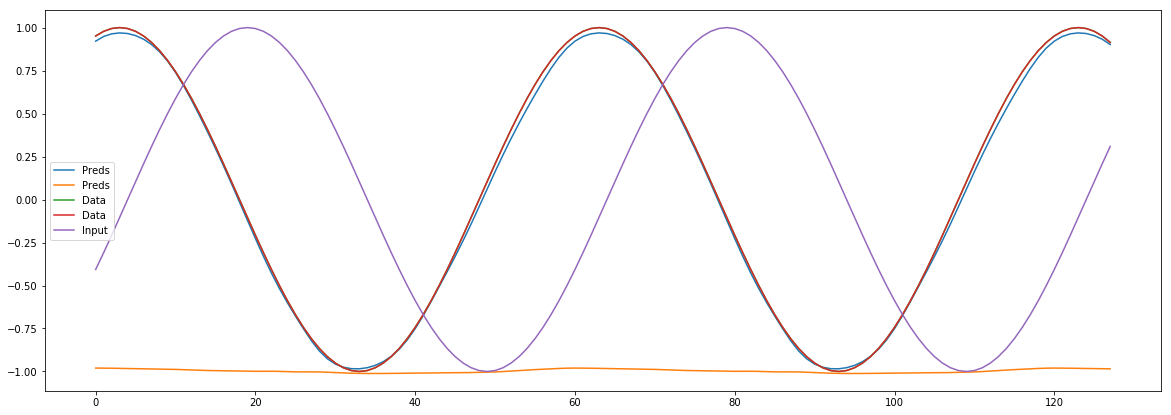

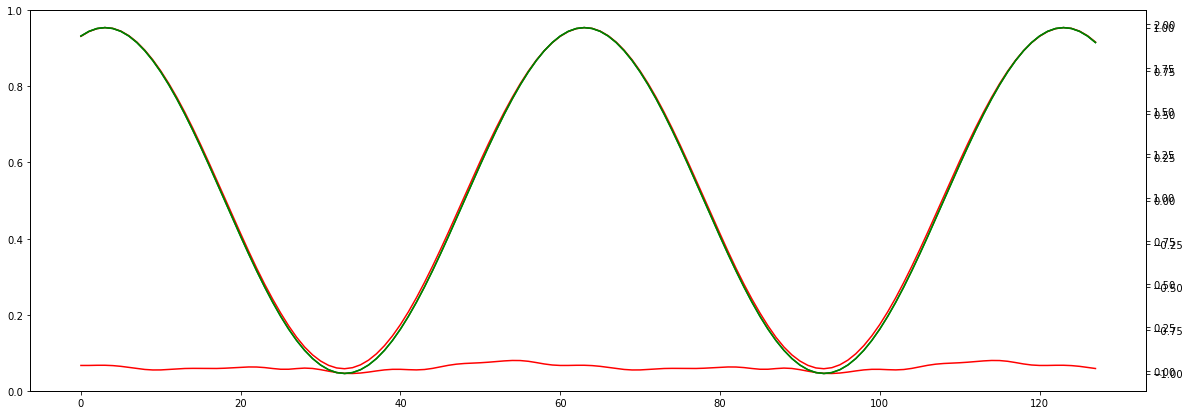

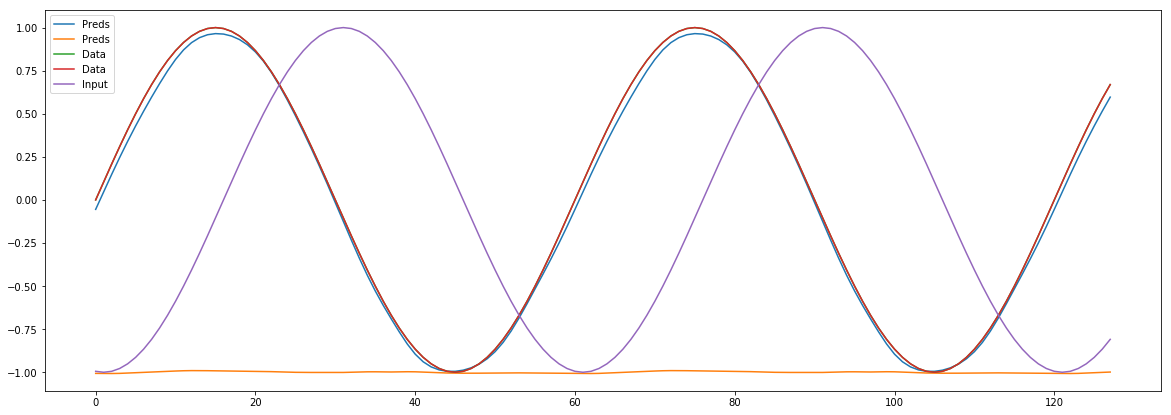

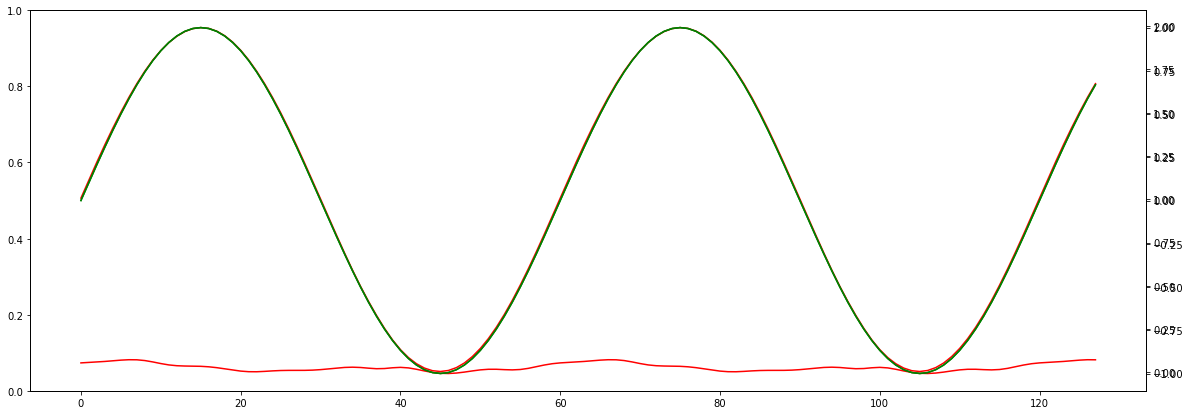

 Epoch [7]     
 train_loss[4.30857481956482]     
 eval_train[4.19483388264974]     
 eval_test[4.175320625305176] 


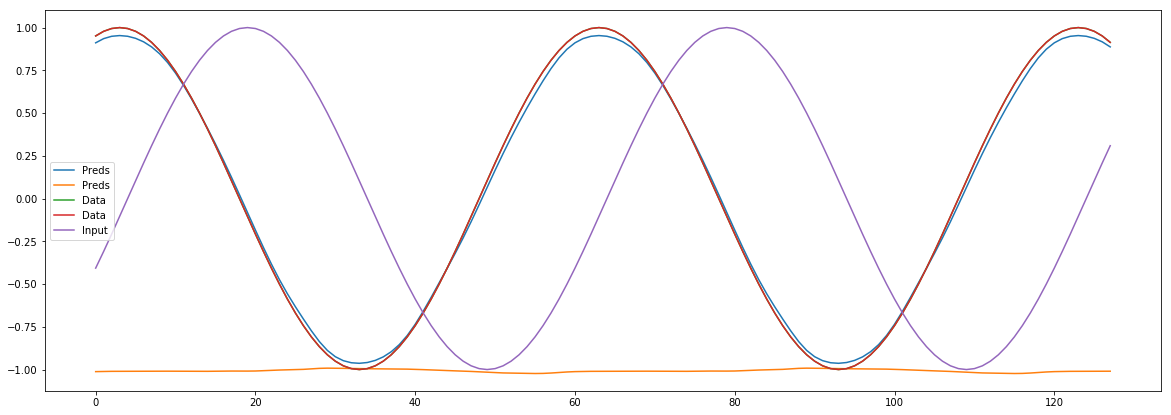

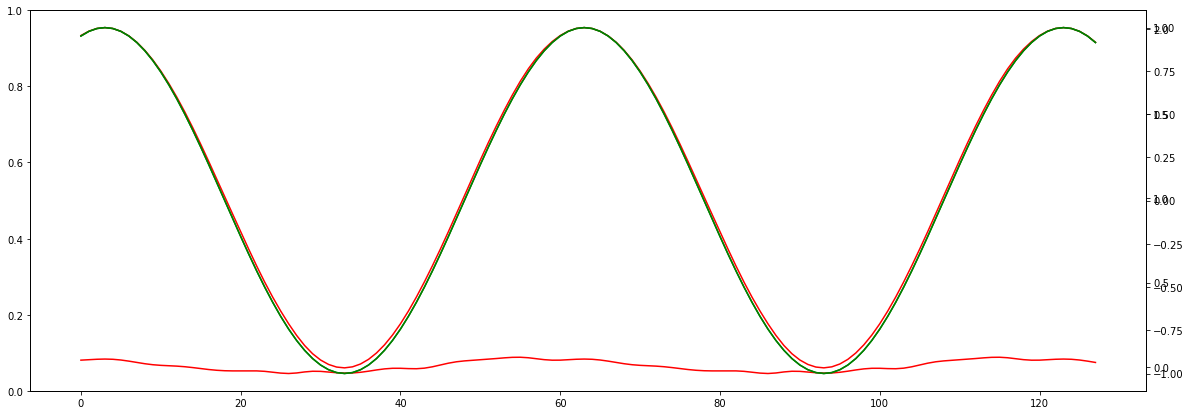

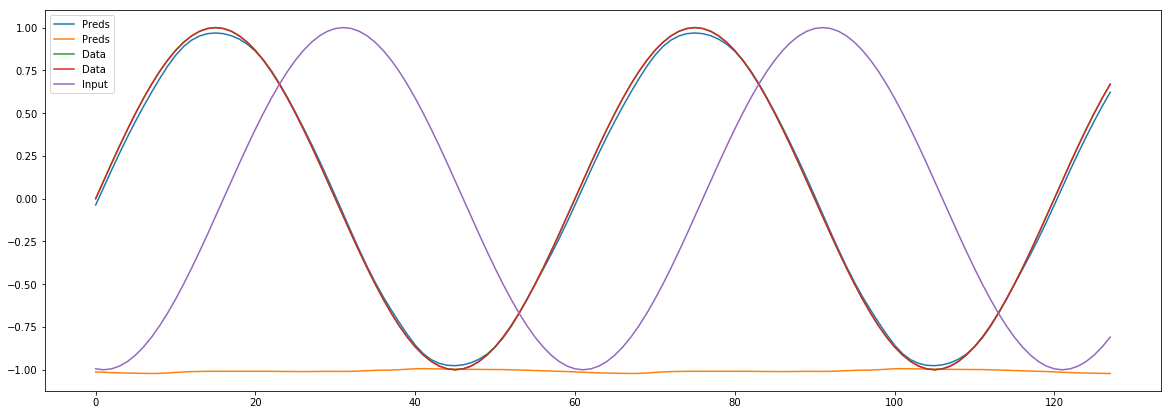

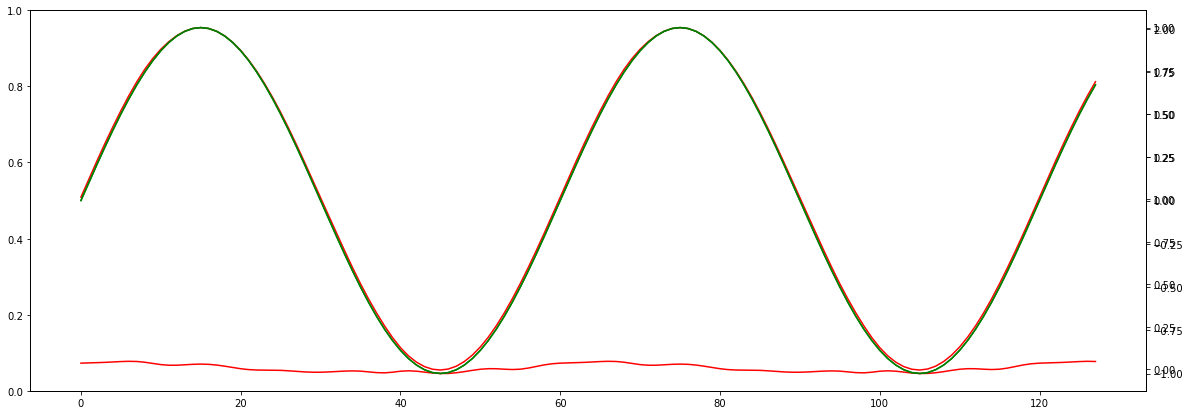

 Epoch [8]     
 train_loss[4.5515371561050415]     
 eval_train[3.0470330715179443]     
 eval_test[3.028639833132426] 


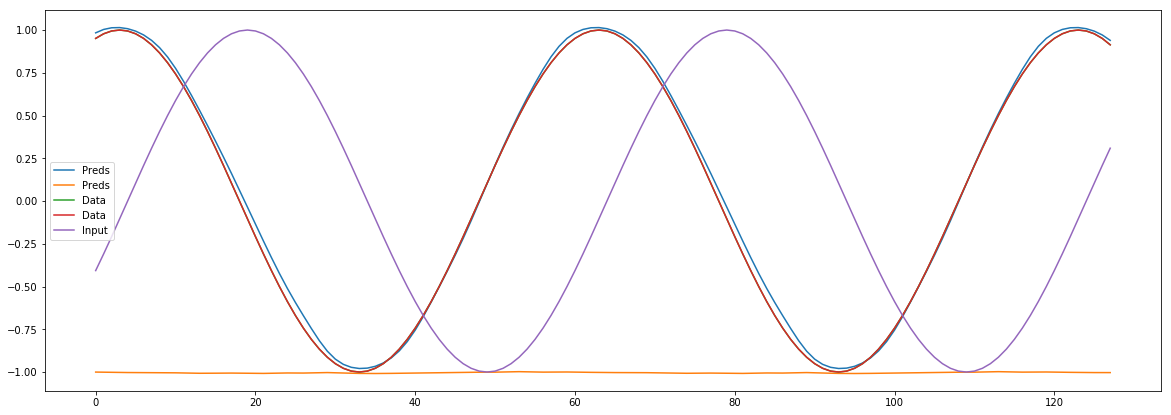

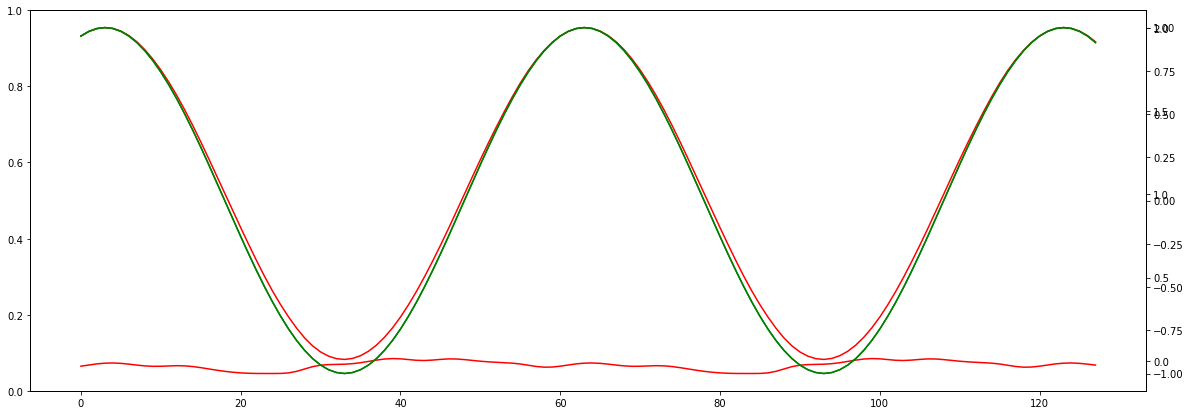

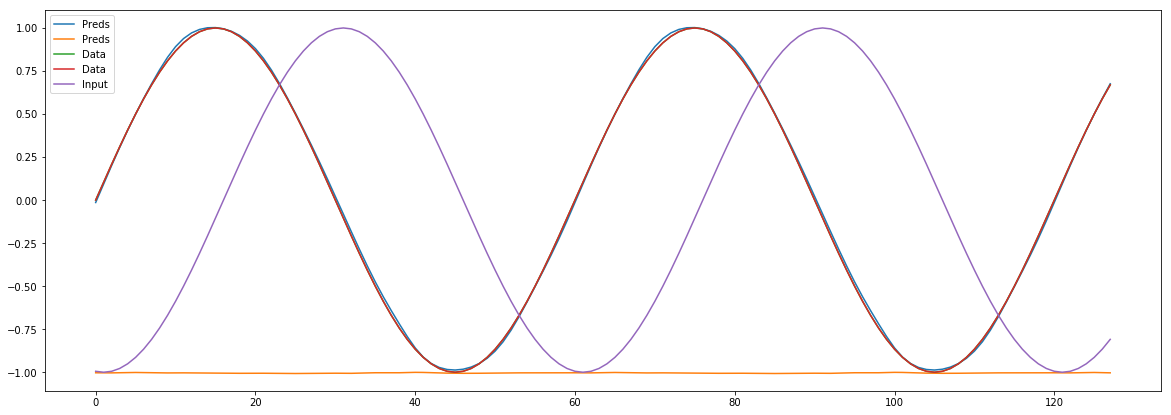

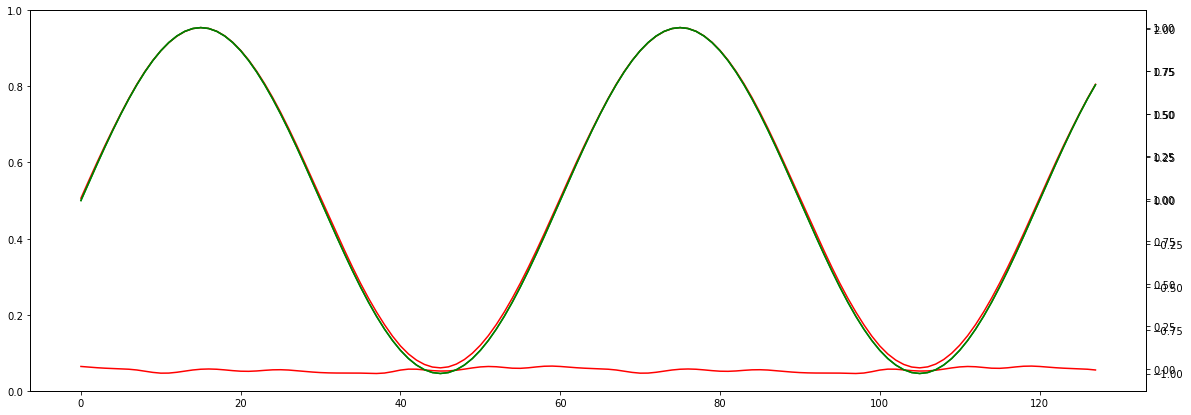

 Epoch [9]     
 train_loss[3.139164090156555]     
 eval_train[2.06585218111674]     
 eval_test[2.061395525932312] 


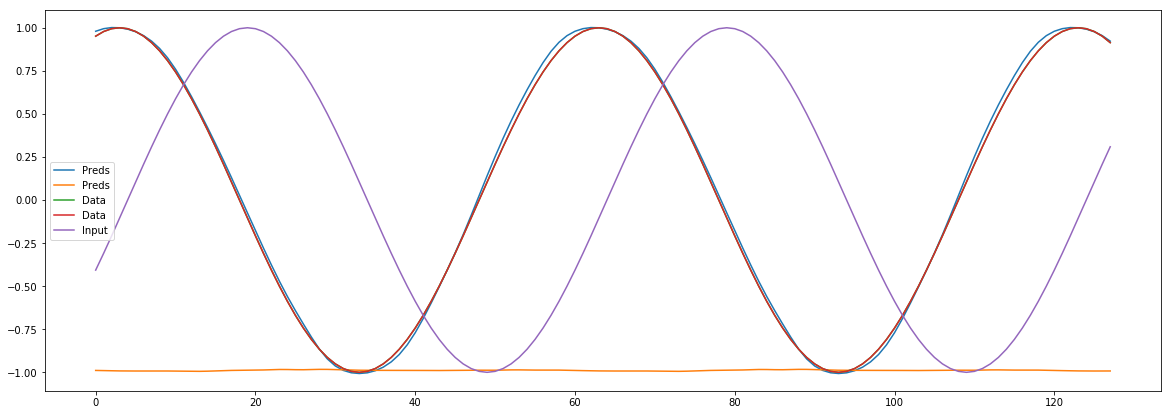

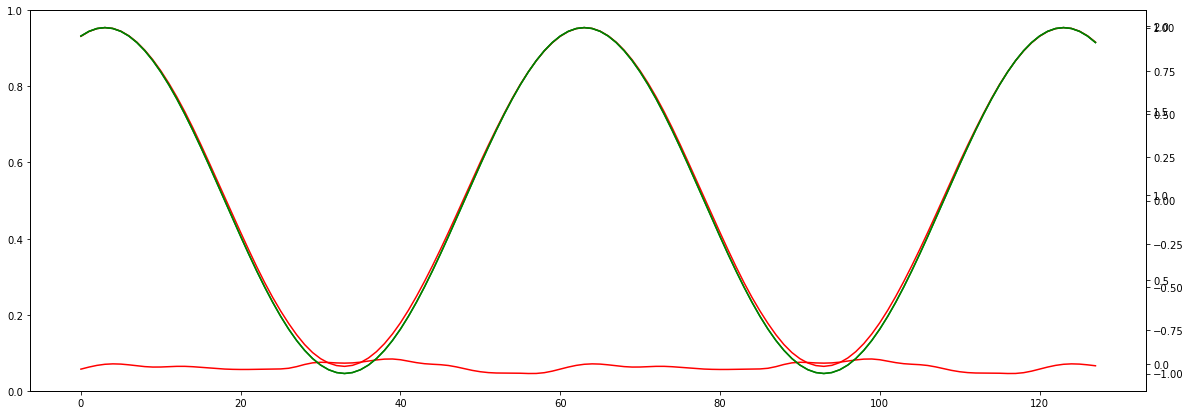

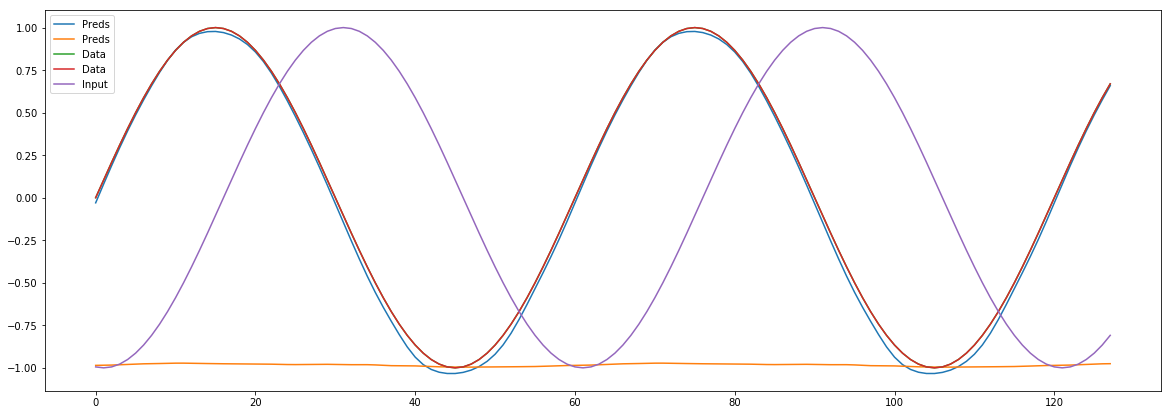

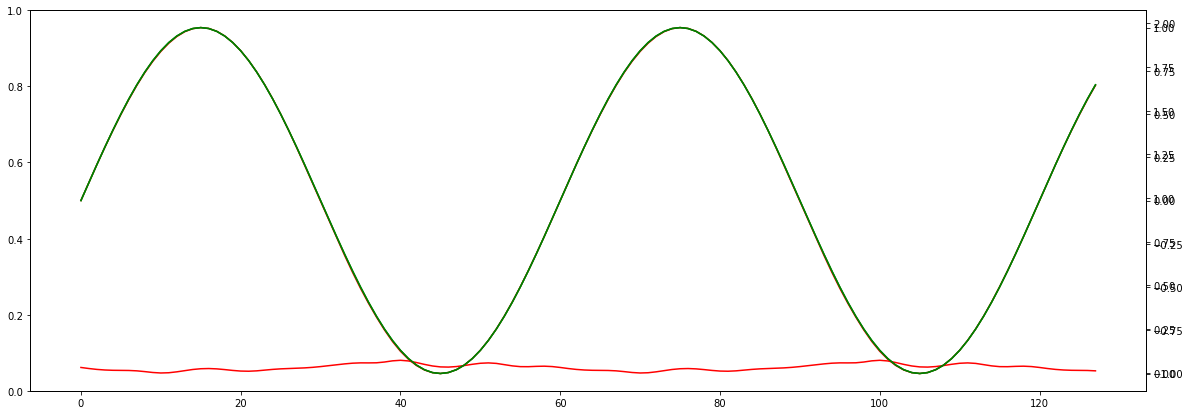

 Epoch [10]     
 train_loss[4.78531322479248]     
 eval_train[4.8987505276997885]     
 eval_test[4.9379691282908125] 


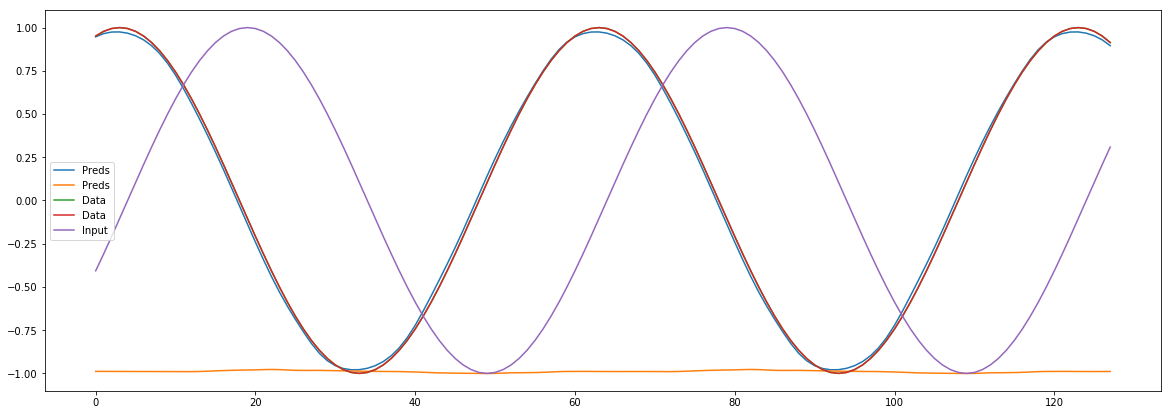

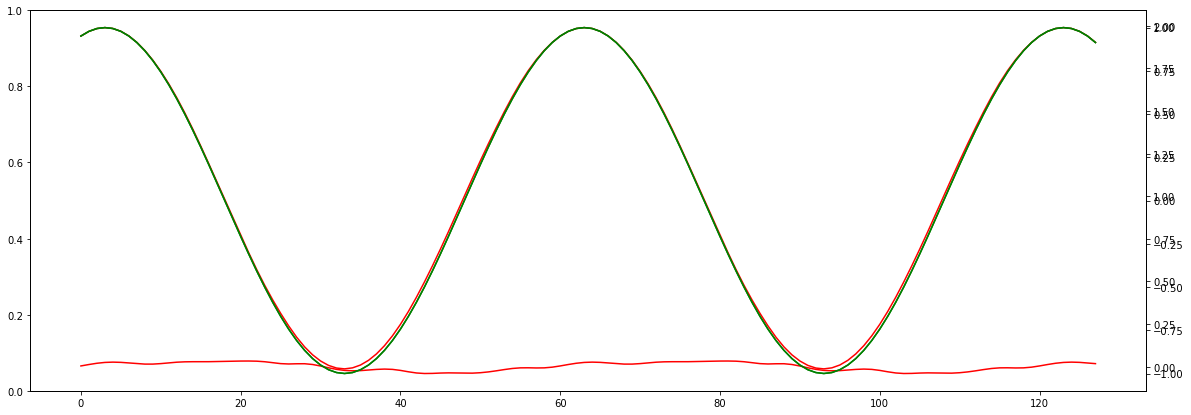

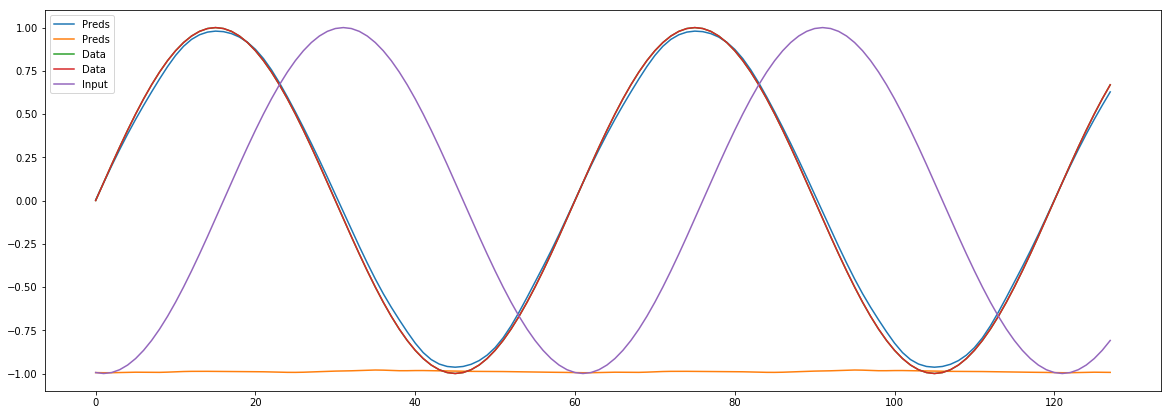

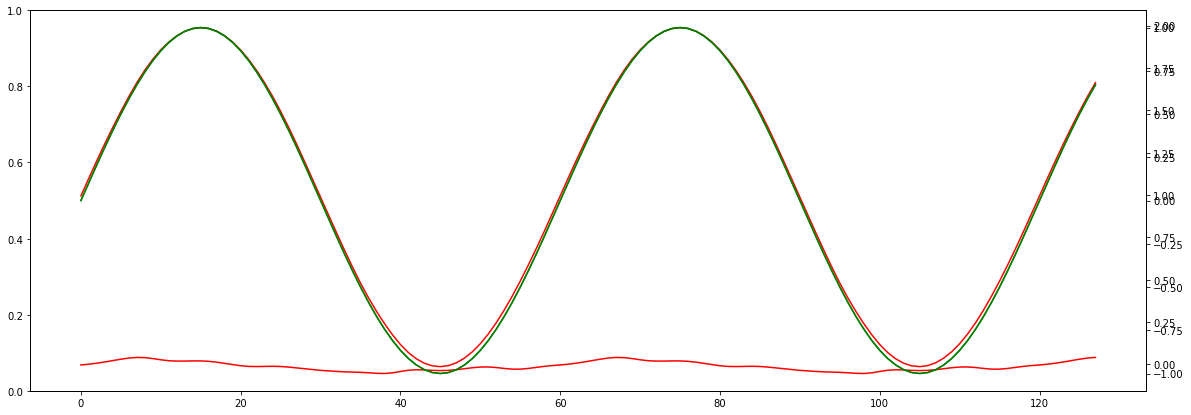

 Epoch [11]     
 train_loss[3.918583043416341]     
 eval_train[3.832423750559489]     
 eval_test[3.844023863474528] 


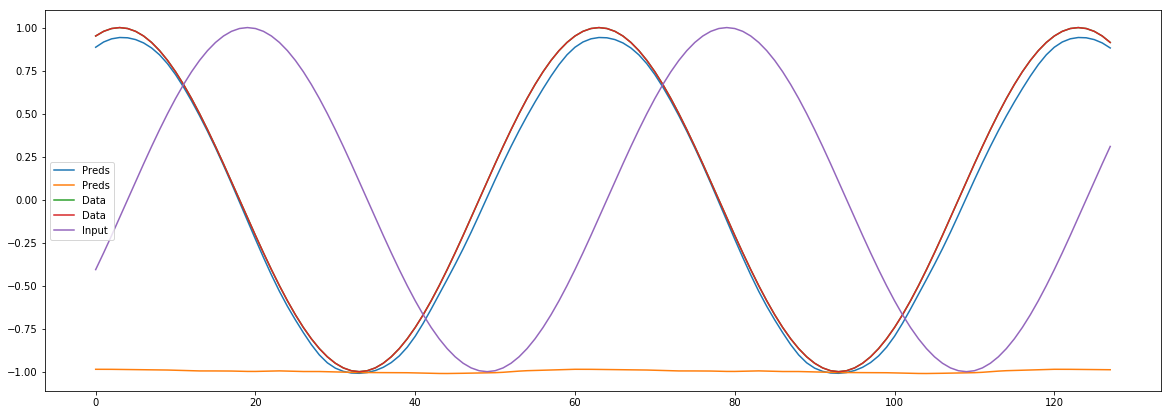

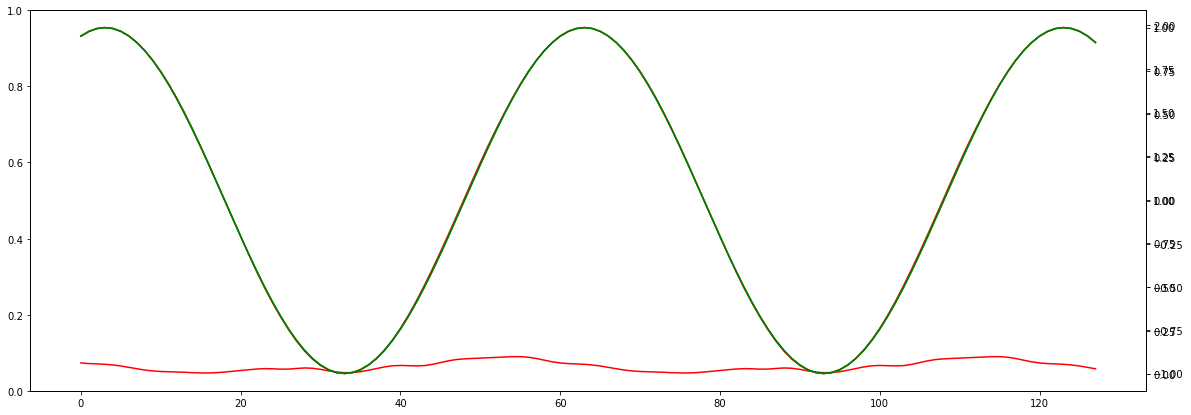

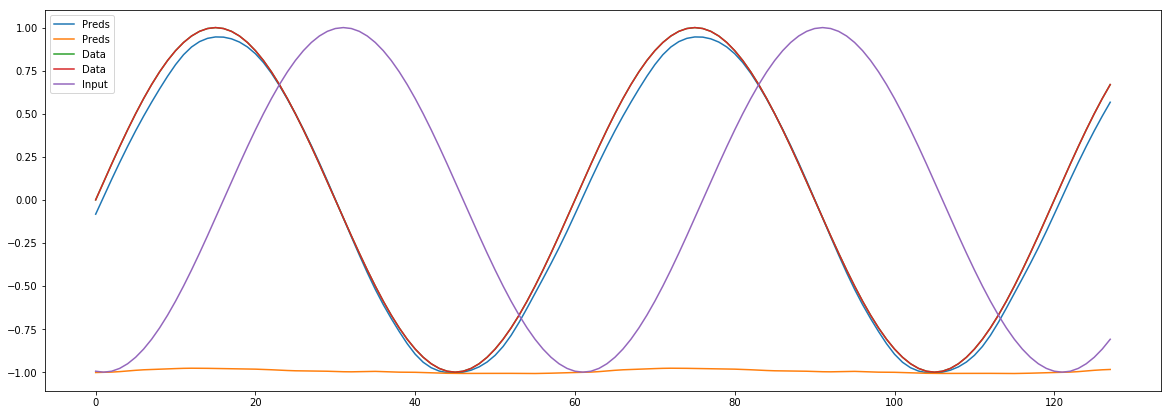

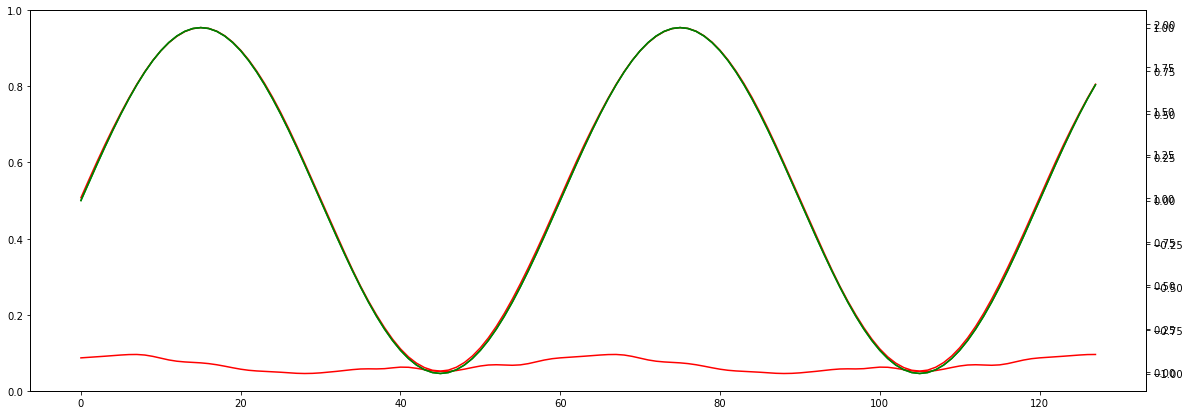

 Epoch [12]     
 train_loss[4.564979139963786]     
 eval_train[5.6769129753112795]     
 eval_test[5.635060469309489] 


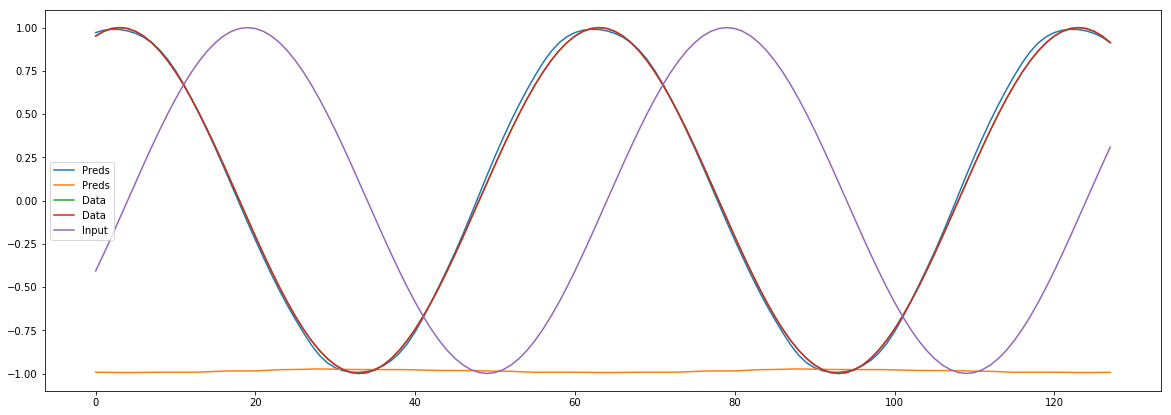

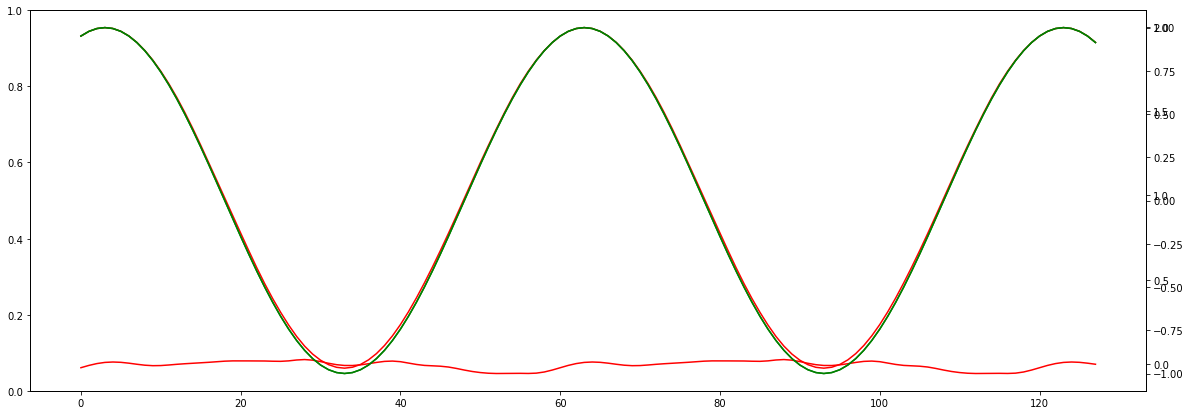

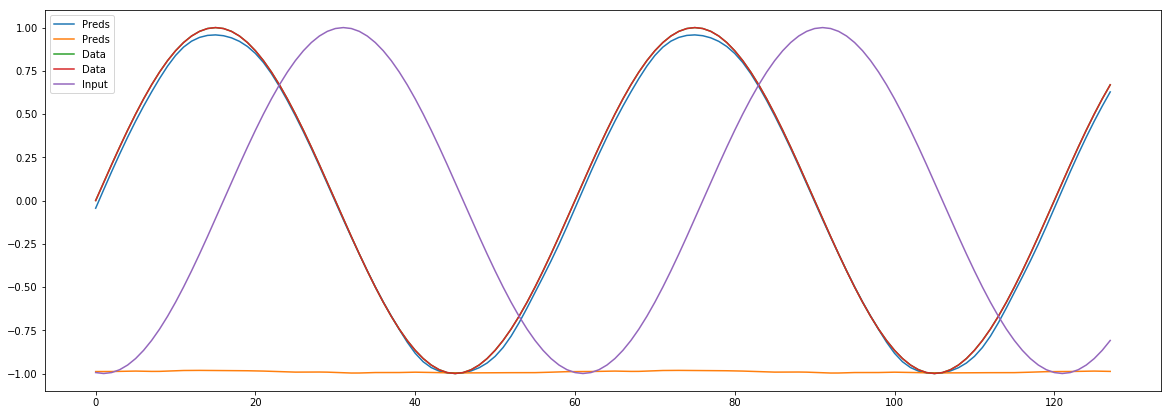

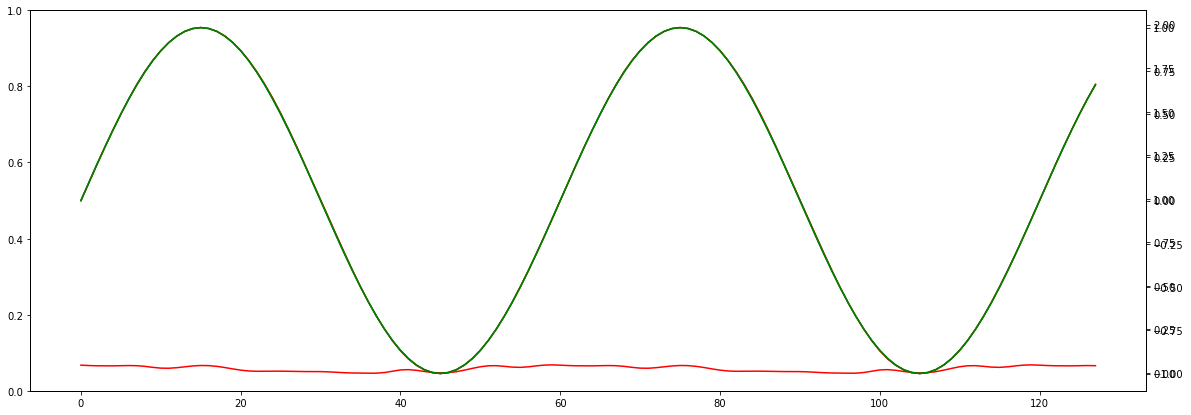

 Epoch [13]     
 train_loss[5.4722477753957115]     
 eval_train[3.4447317918141684]     
 eval_test[3.4214962323506675] 


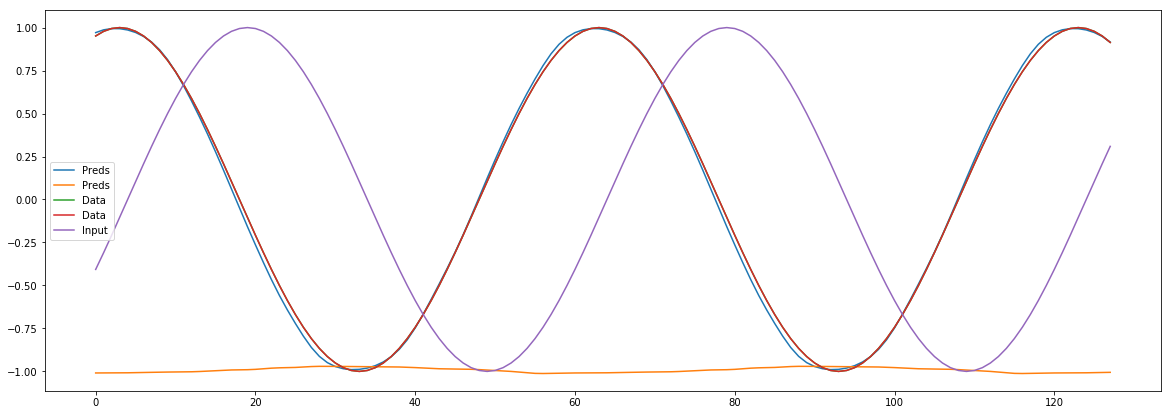

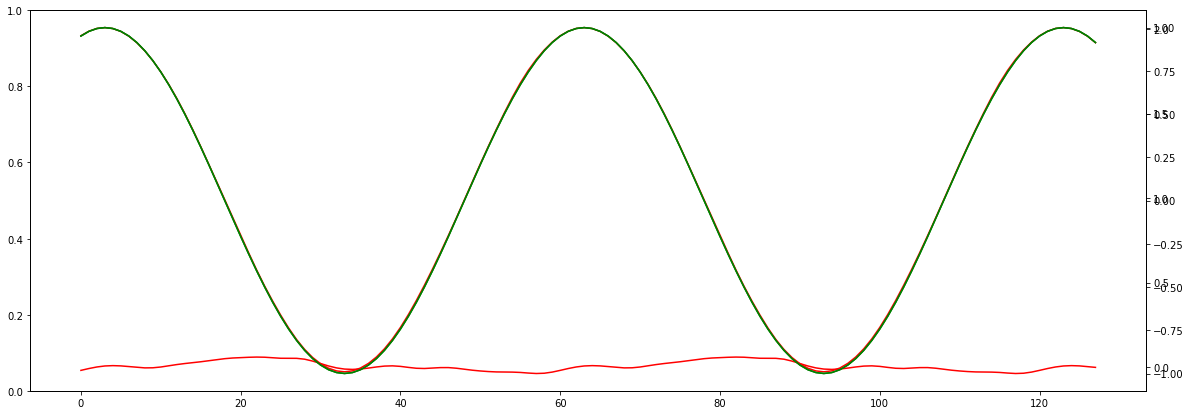

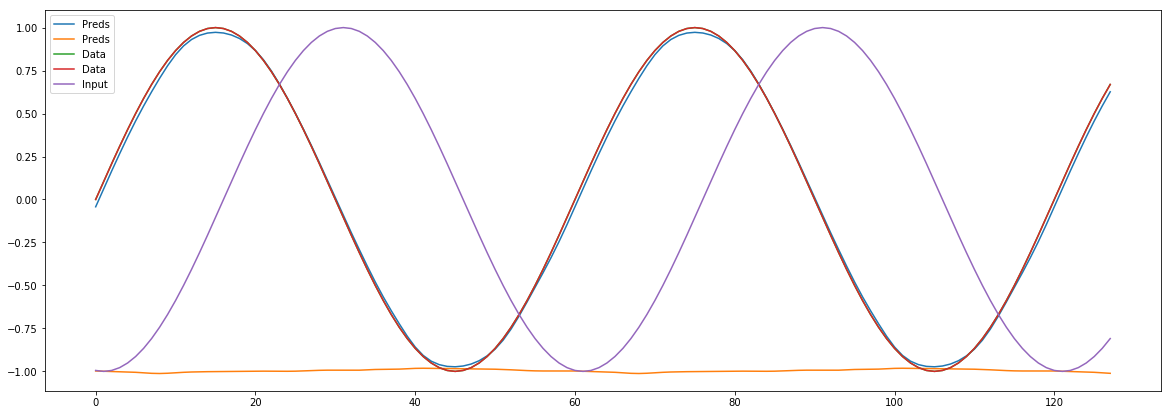

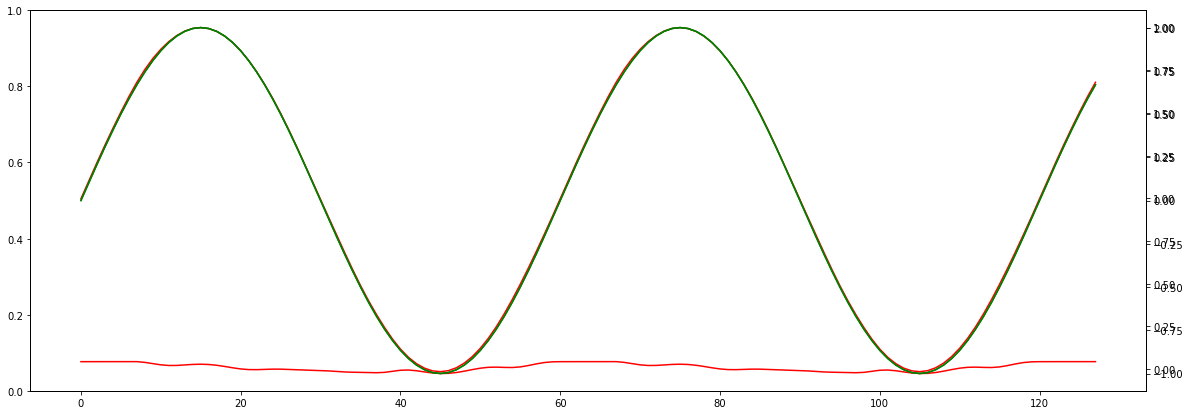

 Epoch [14]     
 train_loss[4.851473824183146]     
 eval_train[3.053924862543742]     
 eval_test[3.0453311602274575] 


In [27]:
#####################
# Train model
#####################

model.hidden = model.init_hidden()
hist = {"train_loss":np.zeros(num_epochs), 
        "train_local_loss":np.zeros(len(train_dl)),
        "eval_train_local":np.zeros(len(train_dl)),
         "eval_test_local":np.zeros(len(test_dl)),
        "eval_train":np.zeros(num_epochs),
         "eval_test":np.zeros(num_epochs),
        
        "aux":{
            "train_loss":np.zeros(num_epochs), 
        "train_local_loss":np.zeros(len(train_dl)),
        "eval_train_local":np.zeros(len(train_dl)),
         "eval_test_local":np.zeros(len(test_dl)),
        "eval_train":np.zeros(num_epochs),
         "eval_test":np.zeros(num_epochs),
        }
        
       }

for t in range(num_epochs):
    
    for i, data in enumerate(tqdm(train_dl)):
        x_batch, y_batch, indexes = data
        x_batch.transpose_(0, 1)
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch, x_batch, config)
        hist['train_local_loss'][i] = loss.item()
        hist['aux']['train_local_loss'][i] = torch.mean(y_pred[:, 1] - a)
        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
    
    
    plot_shared_scale(
        [(y_pred.detach().numpy(),"Preds" ),
         (y_batch.detach().numpy(), "Data"),
         (x_batch[-1].detach().numpy(), "Input")
        ])
    residuals = y_batch-y_pred
    plot_multiscale([(residuals.detach().numpy(), "Red"),
                          (y_batch.detach().numpy(), "Green")]) 
    

        # validate during evaluation
    with torch.no_grad():
        model = model.eval()
        for i, data in enumerate(tqdm(train_dl)):
            x_batch, y_batch, indexes = data
            x_batch.transpose_(0, 1)
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch, x_batch, config)
            hist['eval_train_local'][i] = loss.item()
            hist['aux']['eval_train_local'][i] = torch.mean(y_pred[:, 1] - a)
        for i, data in enumerate(tqdm(test_dl)):
            x_batch_test, y_batch_test, indexes = data
            x_batch_test.transpose_(0, 1)
            y_pred_test = model(x_batch_test)
            loss = loss_fn(y_pred_test, y_batch_test, x_batch_test, config)
            hist['eval_test_local'][i] = loss.item()
            hist['aux']['eval_test_local'][i] = torch.mean(y_pred_test[:, 1] - a)
        model = model.train()

        
#     smoothed_train = []
#     smoothed_test = []
#     k_smooth = 1
#     for elm in range(hist['eval_train_local'][:-k_smooth].shape[0]):
#         smoothed_train.append(np.average(hist['eval_train_local'][elm:elm+k_smooth]))
#     for elm in range(hist['eval_test_local'][:-k_smooth].shape[0]):
#         smoothed_test.append(np.average(hist['eval_test_local'][elm:elm+k_smooth])) 
    
#     plot_shared_scale([
#             (smoothed_train,"Train" ),
#              (smoothed_test, "Test")])        
    
    plot_shared_scale([
        
            (y_pred_test.detach().numpy(),"Preds" ),
             (y_batch_test.detach().numpy(), "Data"),
             (x_batch_test[-1].detach().numpy(), "Input")
    ])

    residuals = y_batch_test - y_pred_test
    plot_multiscale(
            [(residuals.detach().numpy(), "Red"), 
             (y_batch_test.detach().numpy(),"Green")])
#     plot_shared_scale( [ (hist["eval_train_local"], "train"),
#                         (hist["eval_test_local"], "test")])
    logging.info(f"Epoch [{t}] \
    \n train_loss[{hist['train_loss'][t]}] \
    \n eval_traiDn[{hist['eval_train'][t]}] \
    \n eval_test[{hist['eval_test'][t]}] ")
                 
    hist["train_loss"][t] = np.average(hist["train_local_loss"])
    hist["eval_train"][t] = np.average(hist["eval_train_local"])
    hist["eval_test"][t] = np.average(hist["eval_test_local"])
    hist['aux']['eval_test'][t] = np.average(hist['aux']['eval_test_local'])
    hist['aux']['eval_train'][t] = np.average(hist['aux']['eval_train_local'])
    hist['aux']['train_loss'][t] = np.average(hist['aux']['train_local_loss'])
                 
#     hist["aux_error"][t] = np.average[]
    print(f" Epoch [{t}] \
    \n train_loss[{hist['train_loss'][t]}] \
    \n eval_train[{hist['eval_train'][t]}] \
    \n eval_test[{hist['eval_test'][t]}] ")
    logging.info(f" Epoch [{t}] \
    \n train_loss[{hist['train_loss'][t]}] \
    \n eval_train[{hist['eval_train'][t]}] \
    \n eval_test[{hist['eval_test'][t]}] ")

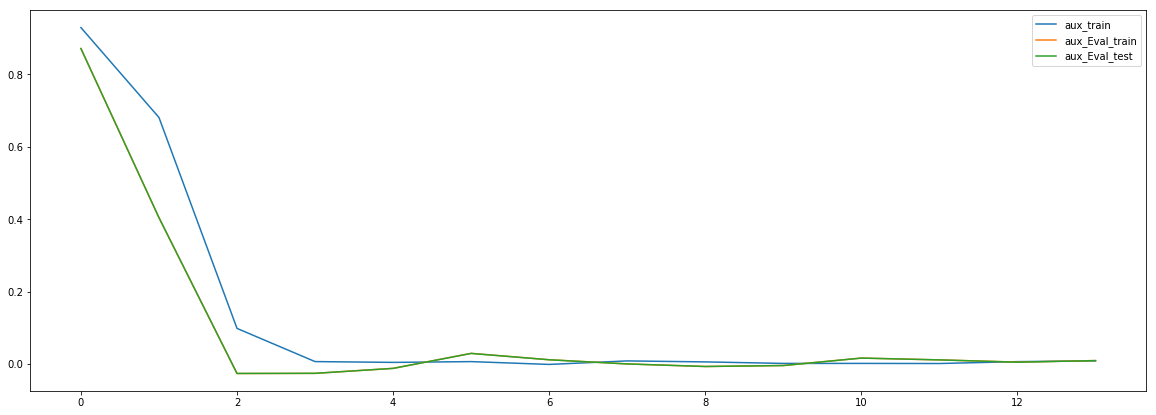

In [28]:
s, e = 0, -1
plot_shared_scale([
#     (hist['train_loss'][s:e],"Train" ),
#              (hist['eval_train'][s:e], "Eval_train"),
#              (hist['eval_test'][s:e], "Eval_test"),
                  (hist['aux']['train_loss'][s:e], "aux_train"),
                  (hist['aux']['eval_train'][s:e], "aux_Eval_train"),
                  (hist['aux']['eval_test'][s:e], "aux_Eval_test")])

In [29]:
model.buffers

<bound method Module.buffers of LSTM(
  (lstm): LSTM(1, 16, num_layers=2)
  (linear): Linear(in_features=16, out_features=2, bias=True)
)>

In [30]:
logging.info("Training process END")

In [31]:
#